# Recurrent Neural Network Basics
---

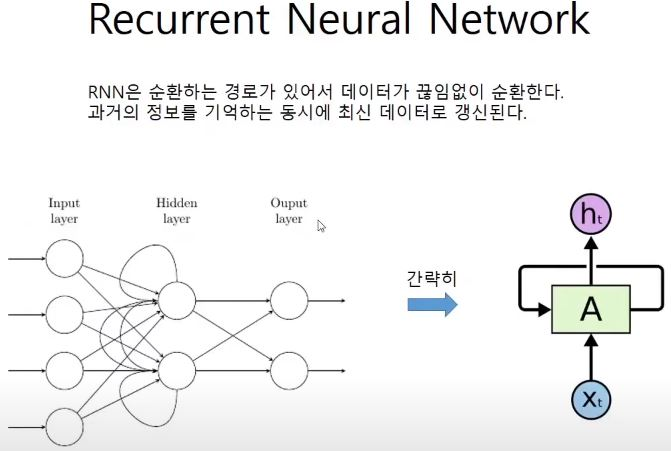

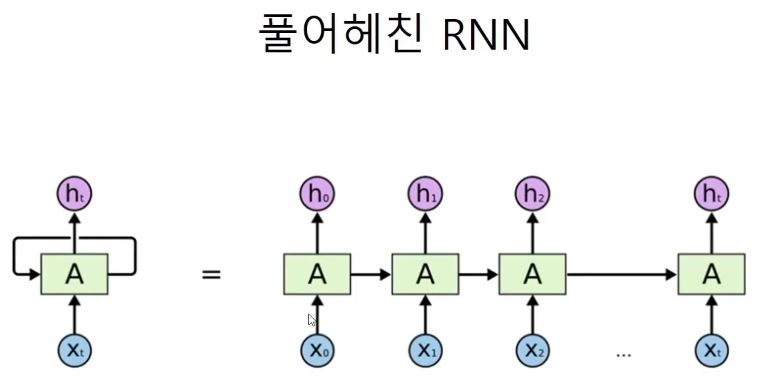

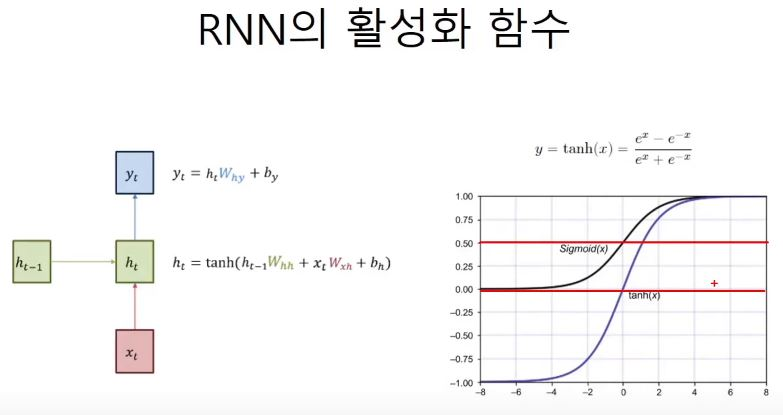

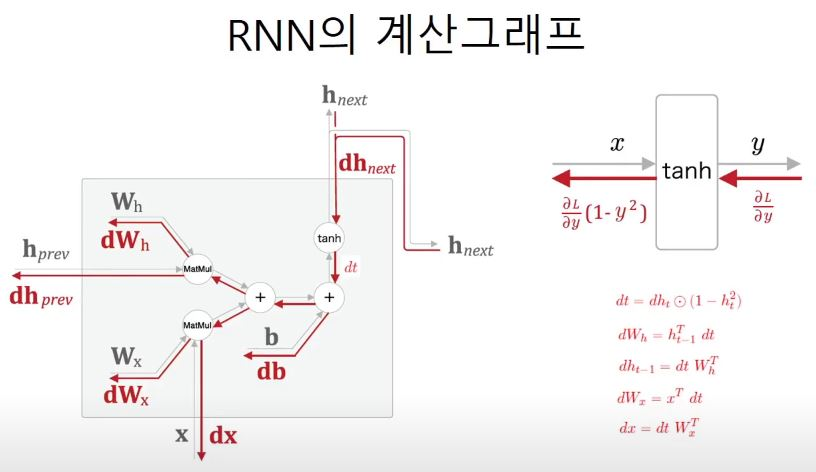

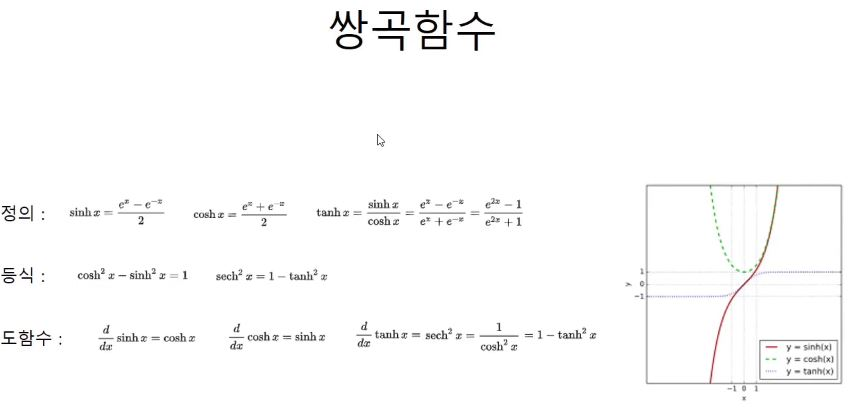

In [1]:
import numpy as np

In [2]:
# the class for RNN layers
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        # zero_grad
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None # for back propagation
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)
        self.cache = (x, h_prev, h_next)
        
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis = 0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        
        # updating the current layer
        self.grads[0][...] = dWx # [...]: deep copy
                                 # self.grads will not be affected
                                 # even though dWx or dWh or db are changed.
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        # Deliver gradients to the previous layer.
        return dx, dh_prev

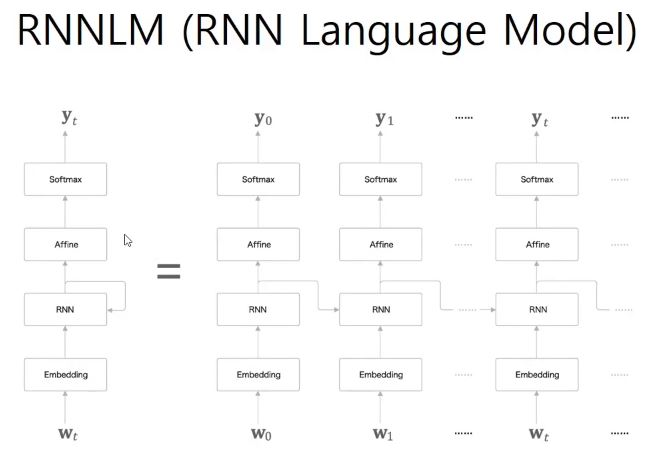
<br>
$w_t$: words

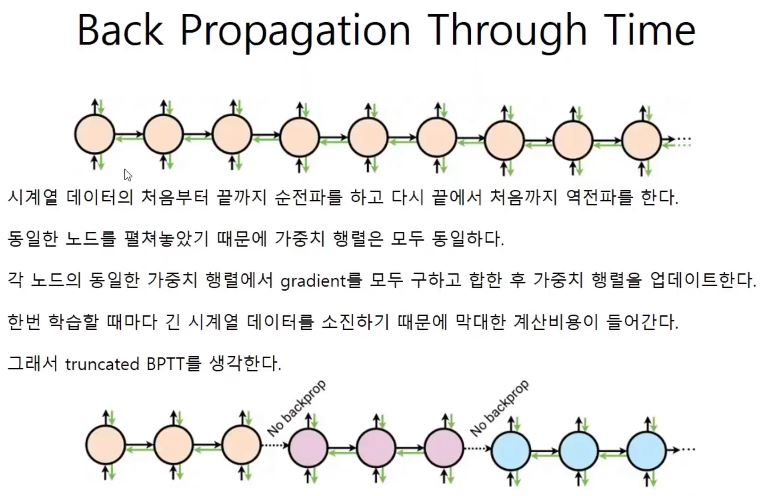
<br>
Do not truncate forward propagation.
Truncate only backward propagation.

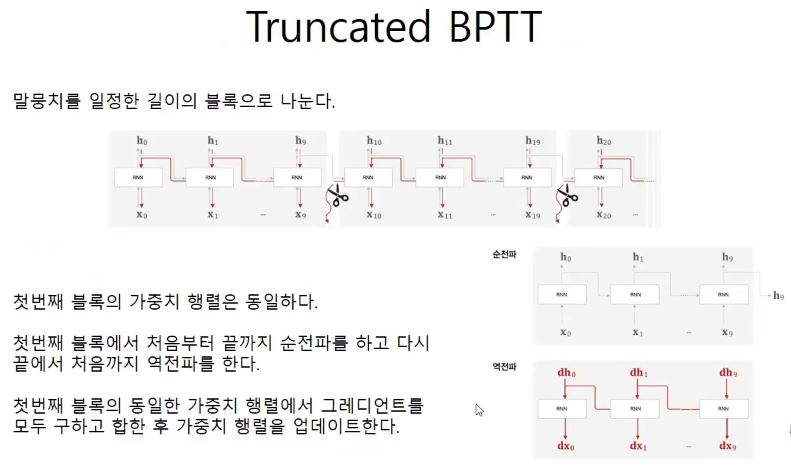

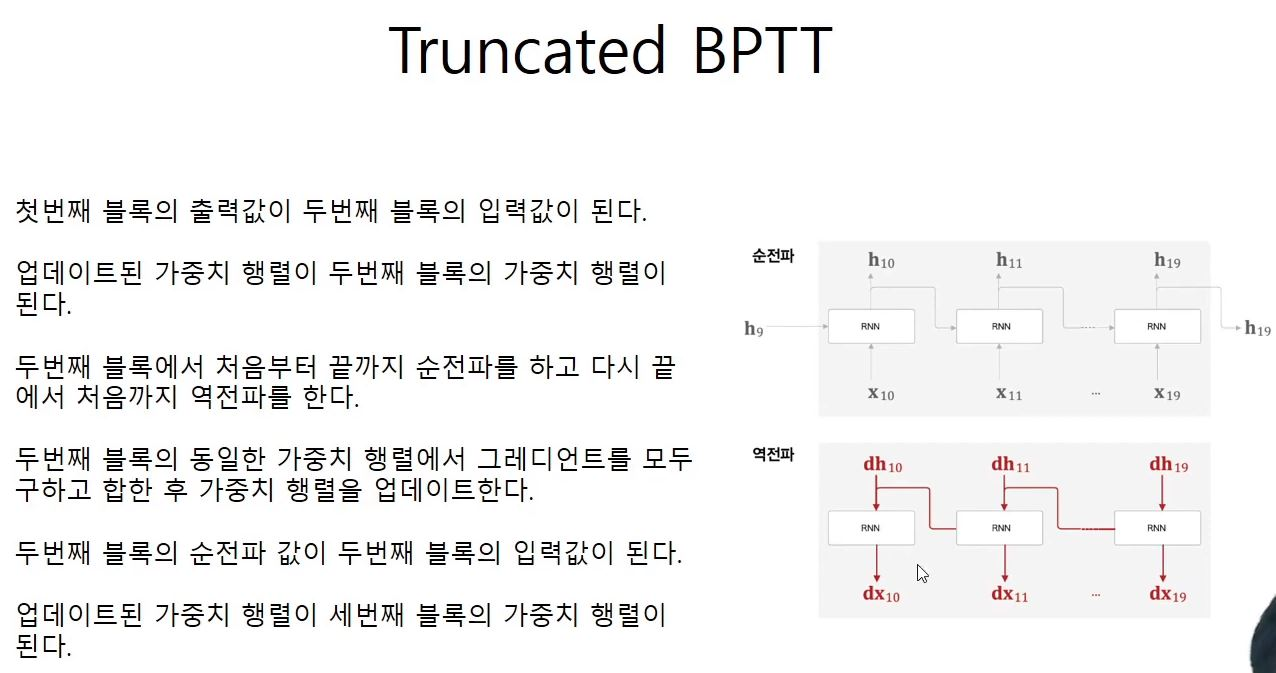

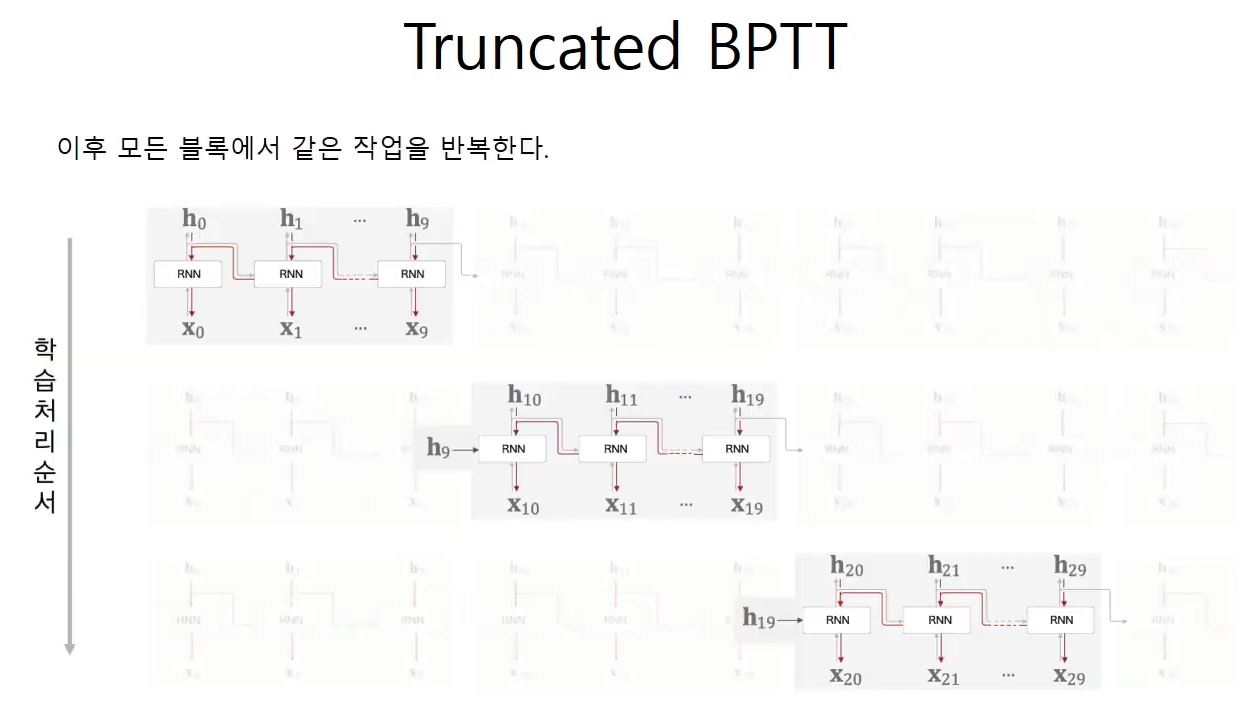

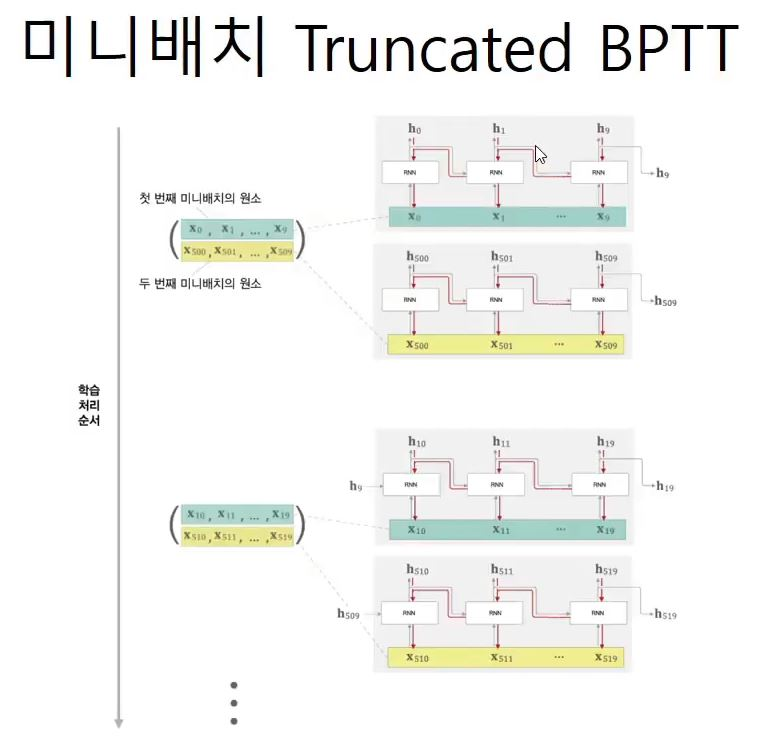

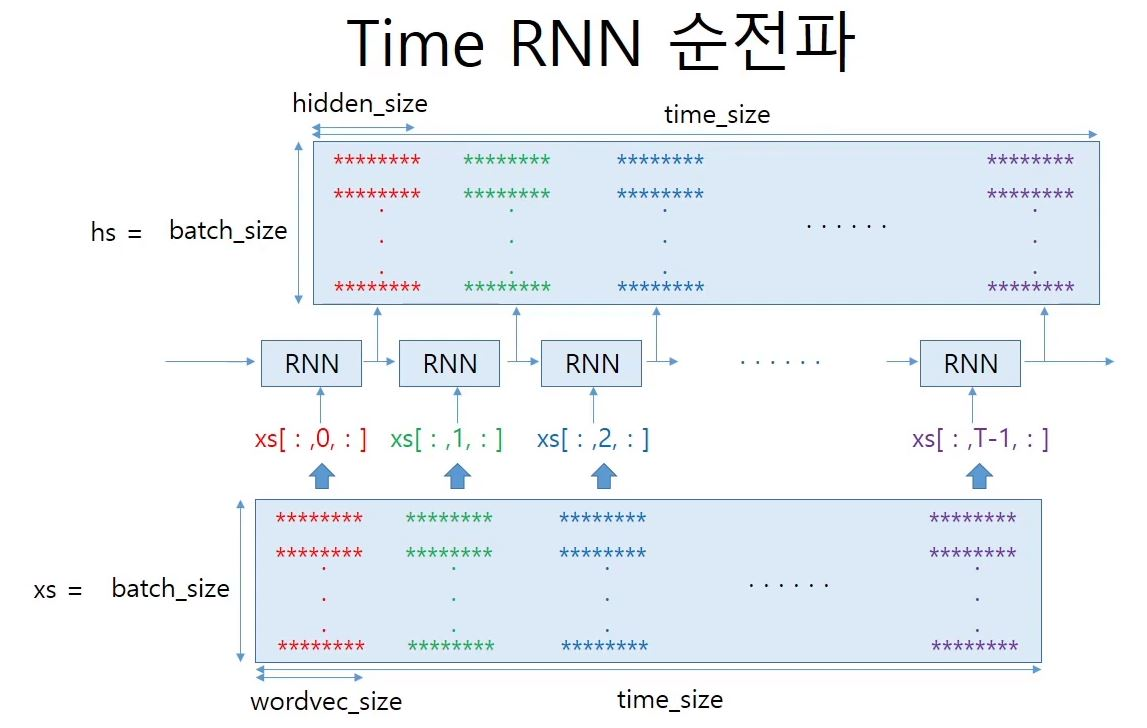

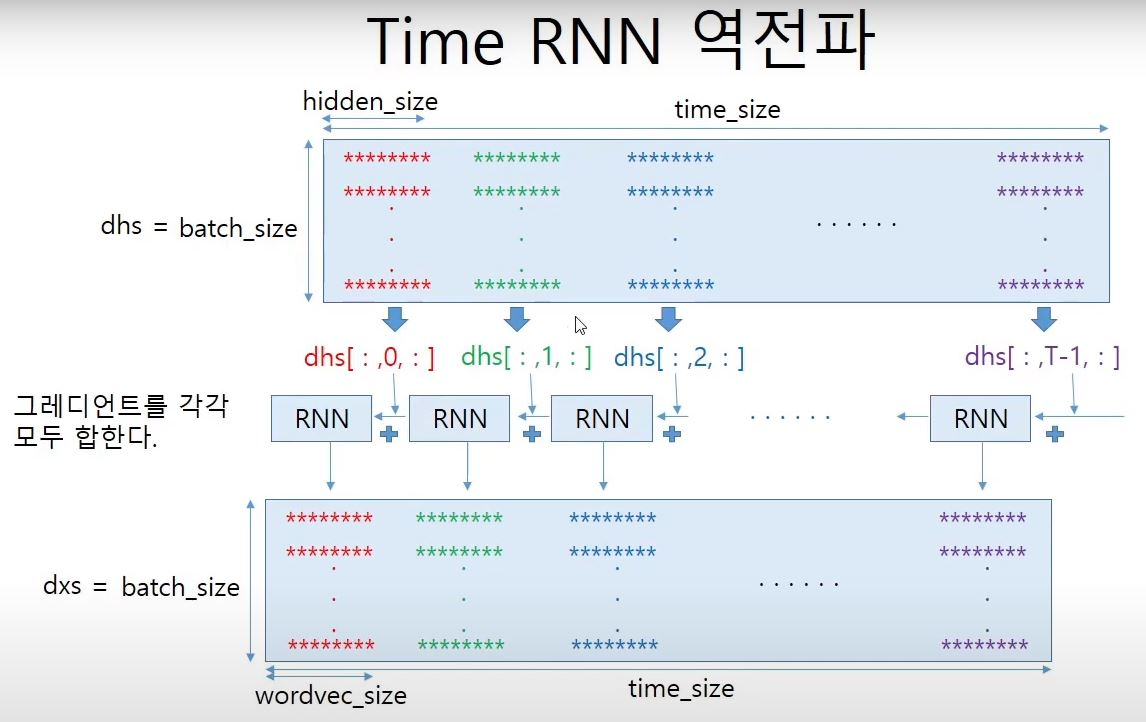

In [3]:
# Truncated Back Propagation Through Time
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful = False):
        # stateful: If True, connect blocks. Otherwise, do no connect them.
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # N: batch size
                           # T: the length of a time block
                           # D: the dimension of embedded vectors (dense vectors)
                           # Recall that we use embedding layer first
                           # before we insert inputs into RNN.
        D, H = Wx.shape    # H: the dimension of vectors generated by hidden layers
        self.layers = [] # as many as 'T'
        hs = np.empty((N, T, H), dtype = 'f') # hs: the collection of hidden states
                                              # It does not matter
                                              # if we use np.empty or np.zeros.
        
        # in order not to connect the previous block's hidden outputs
        # to the next block's hidden layer
        # Or if the initial inputs for hidden is None,
        # set self.h = np.zeros so that RNN calculation can be implemented.
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
            
        # from the first time data to the last time data in a time block
        for t in range(T):
            layer = RNN(*self.params)
            # While the forward method deliver self.h to the next time block,
            # the backward method do not receive dh from the previous time block.
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
        
    def backward(self, dhs):
        Wx, Wh, b = self.params
        # the same as the dimensions in the forward method
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        # zero_grad
        dxs = np.empty((N, T, D), dtype = 'f')
        dh = 0 # the initial dh in a time block must be zeros
               # if h changes -> the loss function of the current time affected
                            # -> the next RNN layer affected
               # dh: gradient from the end of a time block
               # dhs: gradient from the previous RNN layer
        
        # gradients for Wx, Wh, and b
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            # repeat node in a forward node -> sum node in a backward node
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            # self.grads will be used to update weights and biases.
            self.grads[i][...] = grad
        self.dh = dh # redundant line
                     # necessary unless truncated BPTT
        
        return dxs
    
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None

# RNNLM (RNN Language Model)
---

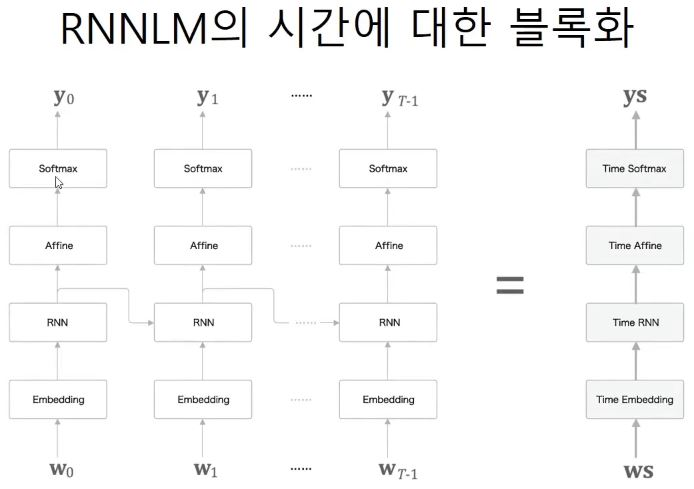

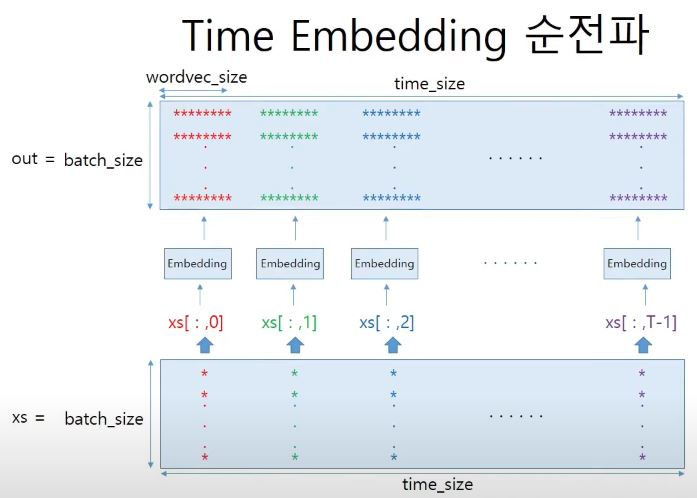
<br>
Input Raw Data: each element $\rightarrow$ integer <br>
Embedded Input Data: each element $\rightarrow$ vector

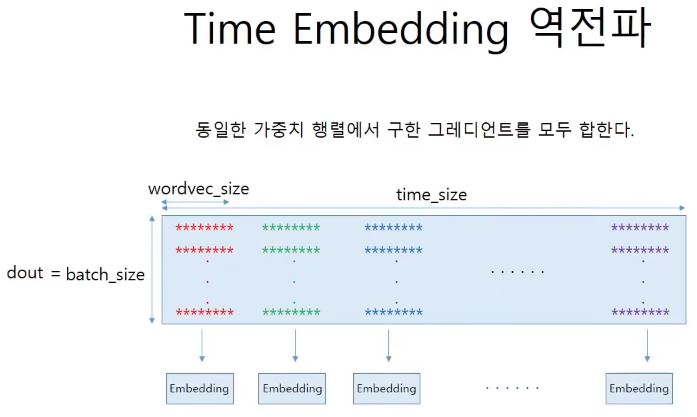

In [4]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        # slicing
        out = W[idx]
        
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        
        return None

In [5]:
# Recall the embedding layer for CBOW models
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
        
    def forward(self, xs):
        N, T = xs.shape # xs: input raw data (2-dimensional tensor)
        V, D = self.W.shape # V: vocab size
                            # D: dense representation (word2vec)
        out = np.empty((N, T, D), dtype = 'f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
            
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape # the same as out in the forward method
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0] # layer: Embedding class
            
        self.grads[0][...] = grad
        
        return None

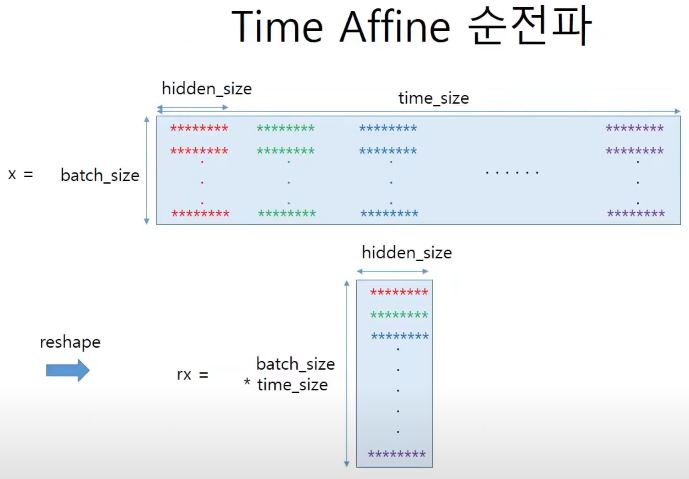

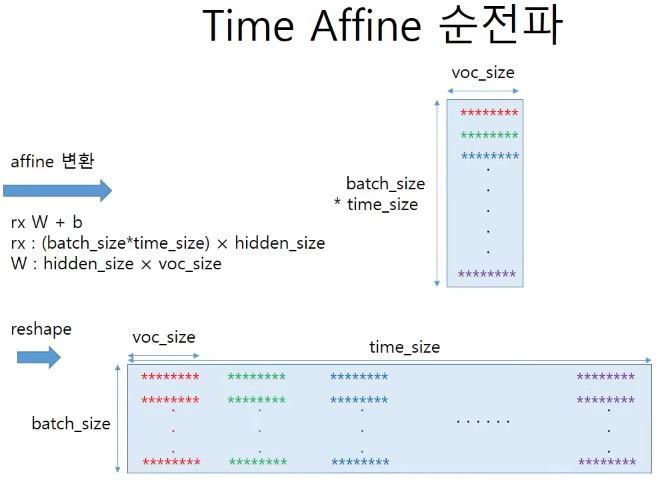

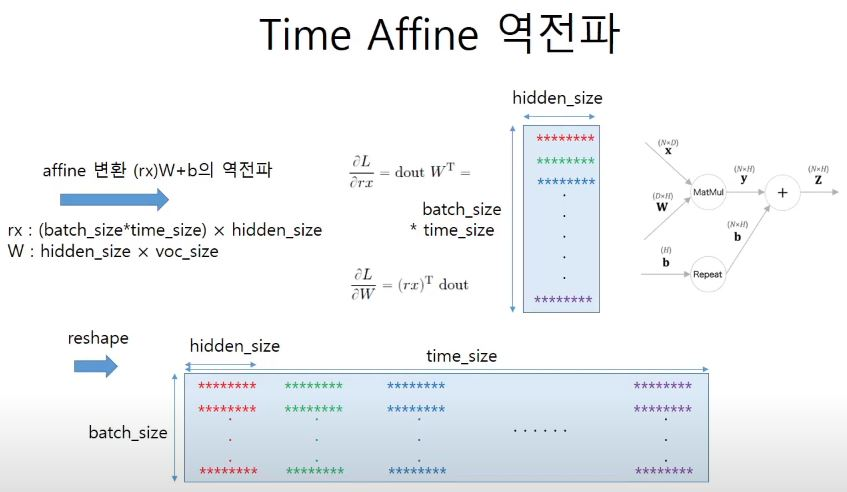

In [6]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        N, T, H = x.shape # H: hidden size
        W, b = self.params
        
        rx = x.reshape(N * T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        
        return out.reshape(N, T, -1)
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N * T, -1)
        rx = x.reshape(N * T, -1)
        db = np.sum(dout, axis = 0) # back prop of a repeat node
                                    # -> sum node
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

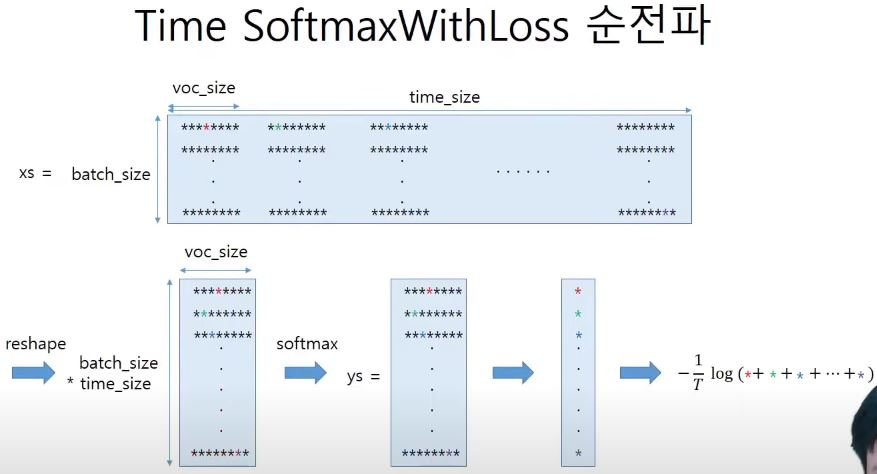

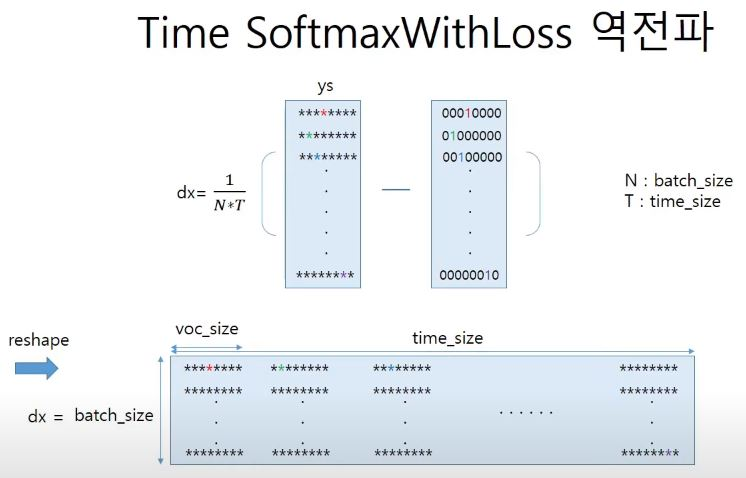

In [7]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis = 1, keepdims = True)
        x = np.exp(x)
        x /= x.sum(axis = 1, keepdims = True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

class TimeSoftMaxWithLoss:
    def __init__(self):
        # Just to unify the format of class definition..
        # We do not need self.params or self.grads
        # for the SoftMax layer.
        self.params, self.grads = [], []
        self.cache = None # for back prop
        self.ignore_label = -1
        
    def forward(self, xs, ts):
        # xs: inputs of the SoftMax layer (scores)
        # ts: the ground truth
        N, T, V = xs.shape
        if ts.ndim == 3: # if the ground truth is an one-hot vector..
            ts = ts.argmax(axis = 2)
        mask = (ts != self.ignore_label)
        mask = mask.reshape(N * T)
        
        # SoftMax
        xs = xs.reshape(N * T, V)
        ys = softmax(xs) # probability distribution
        
        # cross-entropy
        ts = ts.reshape(N * T)
        ls = np.log(ys[np.arange(N * T), ts]) # slicing
                                              # We do not need 'ys' elements
                                              # whose ts elements are zeros.
        ls *= mask # to exclude elements whose ts are zeros
        loss = -np.sum(ls)
        loss /= mask.sum()
        self.cache = (ts, ys, mask, (N, T, V))
        
        return loss
    
    def backward(self, dout = 1):
        ts, ys, mask, (N, T, V) = self.cache
        dx = ys
        dx[np.arange(N * T), ts] -= 1 # dError/dx = y - t
                                      # Error: cross-entropy error
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis] # the shape of mask: (N*T,)
                                  # np.newaxis: add an axis (increasing the mask's rank by 1)
                                  # the shape of mask[:, np.newaxis] -> (N*T, 1)
                                  # multiplying mask: excluding elements which are zeros
        dx = dx.reshape((N, T, V))
        
        return dx

Simple RNNLM

In [8]:
class SimpleRNNLM:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn # Instantiate the function.
        
        # weights initialization
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # dividing by np.sqrt(D)
                                                     # -> LeCun initialization
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # creating layers
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful = True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftMaxWithLoss()
        self.rnn_layer = self.layers[1] # TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful = True)
        
        # parameters and gradients
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        
        return loss
    
    def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

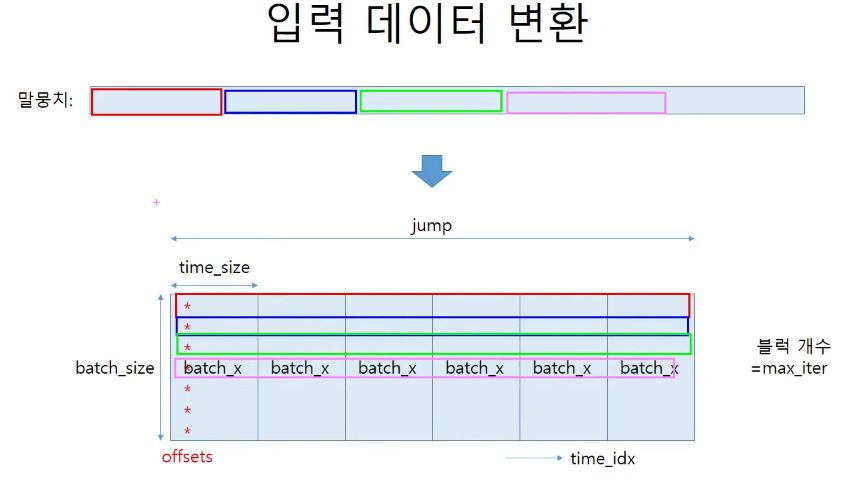 <br>
offset: the position in which the first element is located <br>
offsets $\rightarrow$ 0, 0 + jump, 0 + (2 * jump), ...
<br>
Since temporal order matters for time-series data, we do not shuffle or randomly sample input to train models.

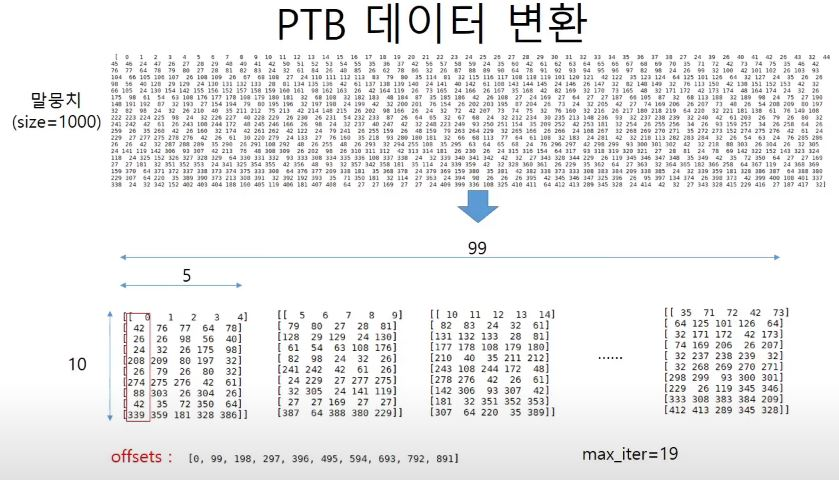<br>
```python
# input data
import chainer

train, val, test = chainer.datasets.get_ptb_words()
# corpus
corpus = train
corpus_size = 1000
corpus = corpus[:corpus_size] # since RNNs do not show good performance
                              # to consider long-term memories..

xs = corpus[:-1] # Exclude the last value.
tx = corpus[1:] # Exclude the first value.
data_size = len(xs)

max_iters = data_size // (batch_size * time_size)
time_idx = 0 # move toward the next column of 'xs'

# jump & offsets
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    # Extract 950 (19 X 5 X 10) integers for each.
    for _ in range(max_iters):
        # mini-batch
        batch_x = np.empty((batch_size, time_size), dtype = 'i')
        batch_y = np.empty((batch_size, time_size), dtype = 'i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
```

xs의 position들이 코딩과 일치시키는 편의상 0부터 998번째 position까지 존재한다고 가정하겠습니다.
첫 번째 epoch이 진행되는 동안에서는 xs의 0-94, 99-193, ..., 891-985 번째 position들이 mini-batches에 편입됩니다. 두 번째 epoch이 시작하고 나면, input data의 첫 번째 mini-batch에서 첫 번째 행은 xs의 95번째 position부터 시작하고, 두 번째 행은 194 (95 + 99) 번째 position부터 시작합니다. 이런 점에서 xs에 있는 총 999개의 수치들 가운데 9개만 첫 번째 epoch에서 누락된다는 것은 잘못된 진술인 것 같습니다. 오히려 첫 번째 epoch부터 이어지는 epochs까지 계속해서 xs 내에 있는 999개 수치들 가운데 49개가 누락되게 되어 있습니다.
한편 이러한 방식으로 두 번째 epoch에서는 xs의 95-189, 194-288, ..., 986-81 번째 position들이 mini-batches에 편입됩니다. 두 번째 epoch에서 19번의 iteration에 걸쳐 모두 950개의 수치들이 embedding layer에 투입됩니다.
마찬가지로, 세 번째 epoch에서는 xs의 190-284, 289-383, ..., 82-176 position들이 mini-batches에 편입됩니다.

그리고 이런 점들을 고려하였을 때, presentation에 있는 jump 표시는 오해를 불러일으킬 소지가 있는 것 같습니다. jump 아래에는 (10 by 5) mini-batch가 왼쪽에서부터 하나씩 그려져 있는데요. 매 epoch마다 19번의 iteration이 있으므로 (10 by 5) tensor가 19번 생성되게 됩니다. 따라서 가로의 길이는 19 X 5 = 95가 되는 것이 자연스러워 보이게 됩니다. 99는 xs에서 mini-batch의 각 행에 추출될 range를 표시하기 위해 만든 것이므로 presentation에 나온 시각화는 다소 오해의 소지가 있어보입니다.

In [9]:
class SGD:
    """
    stochastic gradient descent
    lr: learning rate hyperparameter
    """
    
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

In [10]:
# hyperparameters
batch_size = 10
wordvec_size = 100
hidden_size = 100 # the size of a vector in the RNN hidden layer
time_size = 5 # the time span in the Truncated BPTT
lr = 0.1
max_epoch = 100

In [11]:
# input data
import chainer

train, val, test = chainer.datasets.get_ptb_words()
# corpus
corpus = train
corpus_size = 1000
corpus = corpus[:corpus_size] # since RNNs do not show good performance
                              # to consider long-term memories..

vocab_size = int(max(corpus) + 1)
xs = corpus[:-1] # Exclude the last value.
ts = corpus[1:] # Exclude the first value.
data_size = len(xs)
print(f"The size of the corpus: {corpus_size}\n" \
      f"The number of vocabularies: {vocab_size}")

max_iters = data_size // (batch_size * time_size)
time_idx = 0 # move toward the next column of 'xs'
total_loss = 0
loss_count = 0
ppl_list = [] # perplexity: measuring the performance of neural networks
              # processing natural language
    
# jump & offsets
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

The size of the corpus: 1000
The number of vocabularies: 418


In [12]:
# creating the model
model = SimpleRNNLM(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

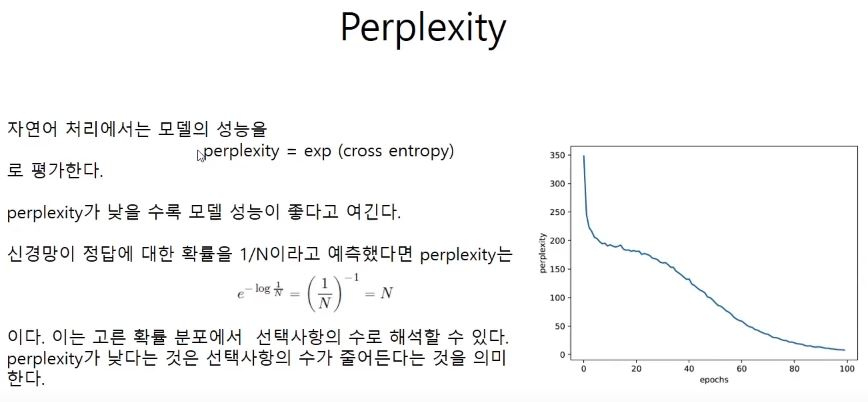

In [13]:
import matplotlib.pyplot as plt

Epoch 1: Perplexity 383.45
Epoch 2: Perplexity 255.90
Epoch 3: Perplexity 224.45
Epoch 4: Perplexity 217.21
Epoch 5: Perplexity 207.70
Epoch 6: Perplexity 203.64
Epoch 7: Perplexity 199.94
Epoch 8: Perplexity 198.08
Epoch 9: Perplexity 191.79
Epoch 10: Perplexity 193.52
Epoch 11: Perplexity 189.86
Epoch 12: Perplexity 192.57
Epoch 13: Perplexity 189.22
Epoch 14: Perplexity 190.05
Epoch 15: Perplexity 189.49
Epoch 16: Perplexity 185.87
Epoch 17: Perplexity 183.05
Epoch 18: Perplexity 179.01
Epoch 19: Perplexity 180.88
Epoch 20: Perplexity 182.44
Epoch 21: Perplexity 179.42
Epoch 22: Perplexity 174.87
Epoch 23: Perplexity 170.84
Epoch 24: Perplexity 173.24
Epoch 25: Perplexity 169.90
Epoch 26: Perplexity 167.81
Epoch 27: Perplexity 163.52
Epoch 28: Perplexity 160.57
Epoch 29: Perplexity 157.43
Epoch 30: Perplexity 151.86
Epoch 31: Perplexity 151.78
Epoch 32: Perplexity 146.86
Epoch 33: Perplexity 144.34
Epoch 34: Perplexity 139.76
Epoch 35: Perplexity 141.97
Epoch 36: Perplexity 133.06
E

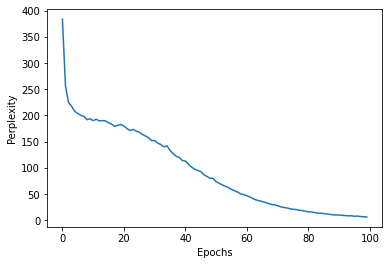

In [14]:
for epoch in range(max_epoch):
    # Extract 950 (19 X 5 X 10) integers for each.
    # time_idx = 94 when the first iteration ends.
    for _ in range(max_iters):
        # mini-batch
        batch_x = np.empty((batch_size, time_size), dtype = 'i')
        batch_t = np.empty((batch_size, time_size), dtype = 'i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        
        # update
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # perplexity
    ppl = np.exp(total_loss / loss_count)
    print(f"Epoch {epoch + 1}: Perplexity {ppl:.2f}")
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0 # total_loss, loss_count initialization
    
# graphs
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label = 'Train')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.show()

In [15]:
# Alternatively, we can use a training class.
import time

class RNNLMTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype = 'i')
        batch_t = np.empty((batch_size, time_size), dtype = 'i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def training(self, xs, ts, max_epoch = 10, batch_size = 20,
                 time_size = 35, max_grad = None, eval_interval = 20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size,
                                                  time_size)

                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print(f"Epoch: {self.current_epoch + 1}\n" \
                          f"Iteration: the {iters + 1}th out of {max_iters}\n" \
                          f"Elapsed Time: {elapsed_time}\n" \
                          f"Perplexity: {ppl:.2f}")
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim = None):
        x = np.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label = 'Train')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity')
        plt.show()

In [16]:
def remove_duplicate(params, grads):
    '''
    If weights are identical,
    add their gradients.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        # Refer to the '__init__' method in SimpleCBOW or SimpleSkipGram.
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # if weights are shared..
                if params[i] is params[j]: # False if one of them is the copy of another..
                    grads[i] += grads[j]  # add gradients
                                          # Recall that there are
                                          # identical weight tensors.
                                          # ex) W_in of CBOW model
                                          #     W_out of SkipGram model
                    find_flg = True
                    params.pop(j) # deleting the 'j'th weight tensor
                    grads.pop(j) # deleting the 'j'th gradient tensor
                # else if weights are shared in a transposed manner..
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [17]:
model = SimpleRNNLM(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RNNLMTrainer(model, optimizer)

Epoch: 1
Iteration: the 1th out of 19
Elapsed Time: 0.002999544143676758
Perplexity: 420.03
Epoch: 2
Iteration: the 1th out of 19
Elapsed Time: 0.05000877380371094
Perplexity: 399.40
Epoch: 3
Iteration: the 1th out of 19
Elapsed Time: 0.09901952743530273
Perplexity: 284.23
Epoch: 4
Iteration: the 1th out of 19
Elapsed Time: 0.14803314208984375
Perplexity: 222.77
Epoch: 5
Iteration: the 1th out of 19
Elapsed Time: 0.19504046440124512
Perplexity: 212.44
Epoch: 6
Iteration: the 1th out of 19
Elapsed Time: 0.24305319786071777
Perplexity: 210.21
Epoch: 7
Iteration: the 1th out of 19
Elapsed Time: 0.291062593460083
Perplexity: 202.24
Epoch: 8
Iteration: the 1th out of 19
Elapsed Time: 0.33907318115234375
Perplexity: 201.45
Epoch: 9
Iteration: the 1th out of 19
Elapsed Time: 0.38808441162109375
Perplexity: 196.31
Epoch: 10
Iteration: the 1th out of 19
Elapsed Time: 0.4400973320007324
Perplexity: 192.20
Epoch: 11
Iteration: the 1th out of 19
Elapsed Time: 0.4891085624694824
Perplexity: 193.11


Epoch: 93
Iteration: the 1th out of 19
Elapsed Time: 4.6364195346832275
Perplexity: 9.15
Epoch: 94
Iteration: the 1th out of 19
Elapsed Time: 4.688429594039917
Perplexity: 8.74
Epoch: 95
Iteration: the 1th out of 19
Elapsed Time: 4.73944091796875
Perplexity: 8.24
Epoch: 96
Iteration: the 1th out of 19
Elapsed Time: 4.7884521484375
Perplexity: 7.53
Epoch: 97
Iteration: the 1th out of 19
Elapsed Time: 4.8377845287323
Perplexity: 7.55
Epoch: 98
Iteration: the 1th out of 19
Elapsed Time: 4.88695502281189
Perplexity: 7.12
Epoch: 99
Iteration: the 1th out of 19
Elapsed Time: 4.935966730117798
Perplexity: 6.96
Epoch: 100
Iteration: the 1th out of 19
Elapsed Time: 4.98569655418396
Perplexity: 6.63


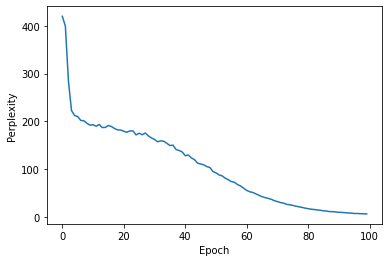

In [18]:
trainer.training(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()

# RNN with Gates
---

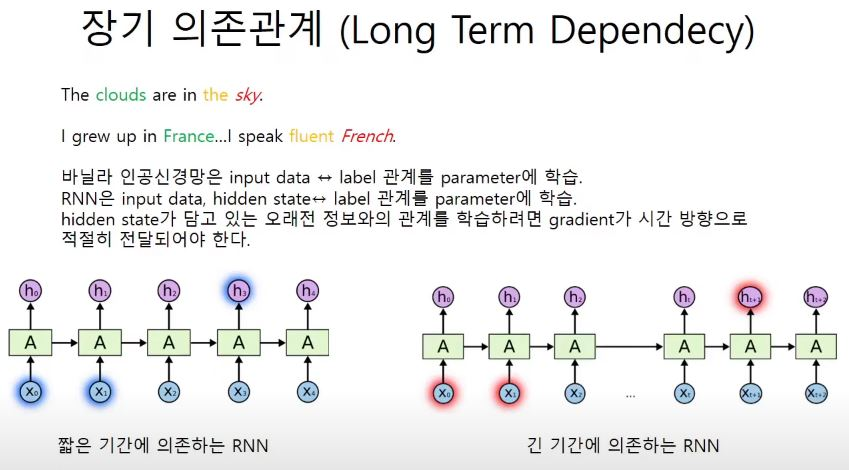

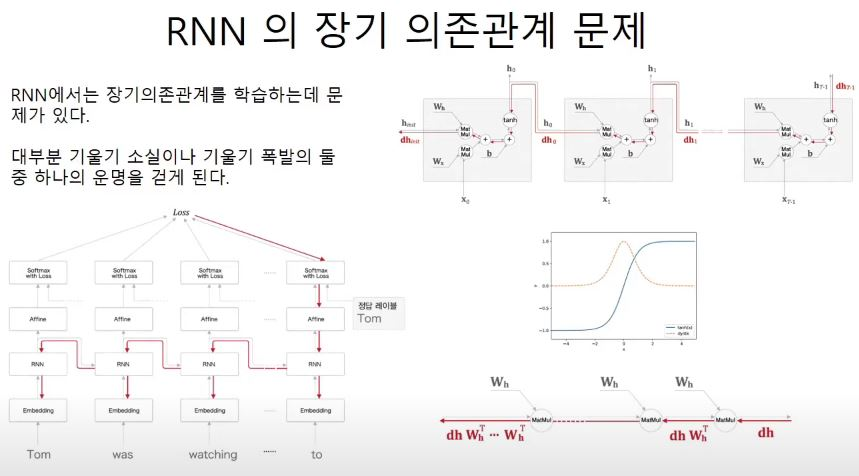
<br>
Just as numbers get smaller if they are continuously multiplied by values whose absolute value are less than 1, matrices are also decreased if they are continuously multiplied by other matrices whose matrix norms are less than 1.

Vanishing Gradient & Exploding Gradient Examples

[1.324232774283581, 1.2270732156853745, 0.39523277519447936, 0.3772952907030117, 0.18675534249442063, 0.14796587242438874, 0.09209710337607416, 0.06540393349093793, 0.04342533256569582, 0.02986169012648272, 0.020168506879367495, 0.0137487999393554, 0.009327897719243548, 0.006344092642148654, 0.004309299286190409, 0.0029290450829361674, 0.0019902162752623936, 0.0013525370645188065, 0.000919093427590182, 0.0006245826373956891]


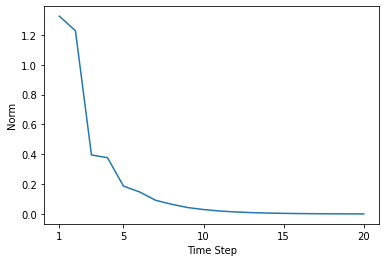

In [19]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # the size of mini-batch
H = 3 # the hidden layer output size
T = 20 # the length of time-series data

np.random.seed(3)

# weights initialization
# Choose one.
Wh = np.random.randn(H, H) # exploding gradient example
Wh = np.random.randn(H, H) * 0.5 # vanishing gradient example

dh = np.ones((N, H)) # gradients initialization

norm_list = []
# RNN back propagation toy example
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
print(norm_list)

# graph
plt.plot(np.arange(len(norm_list)), norm_list)
# plt.xticks(a, b): a -> positions, b -> values
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('Time Step')
plt.ylabel('Norm')
plt.show()

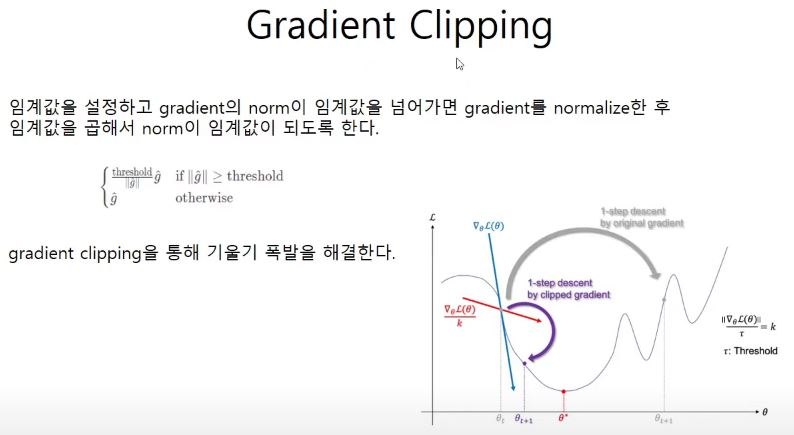

Gradient Clipping Example

In [20]:
dW1 = np.random.rand(3, 3) * 10 # standard deviation: 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

print("Before: ", dW1.flatten())
clip_grads(grads, max_norm)
print("After: ", dW1.flatten())

Before:  [2.83525082 6.93137918 4.40453718 1.56867738 5.44649018 7.80314765
 3.06363532 2.21957884 3.87971258]
After:  [0.54849516 1.34091414 0.85208239 0.30346943 1.05365404 1.50956263
 0.59267742 0.42938996 0.75055213]


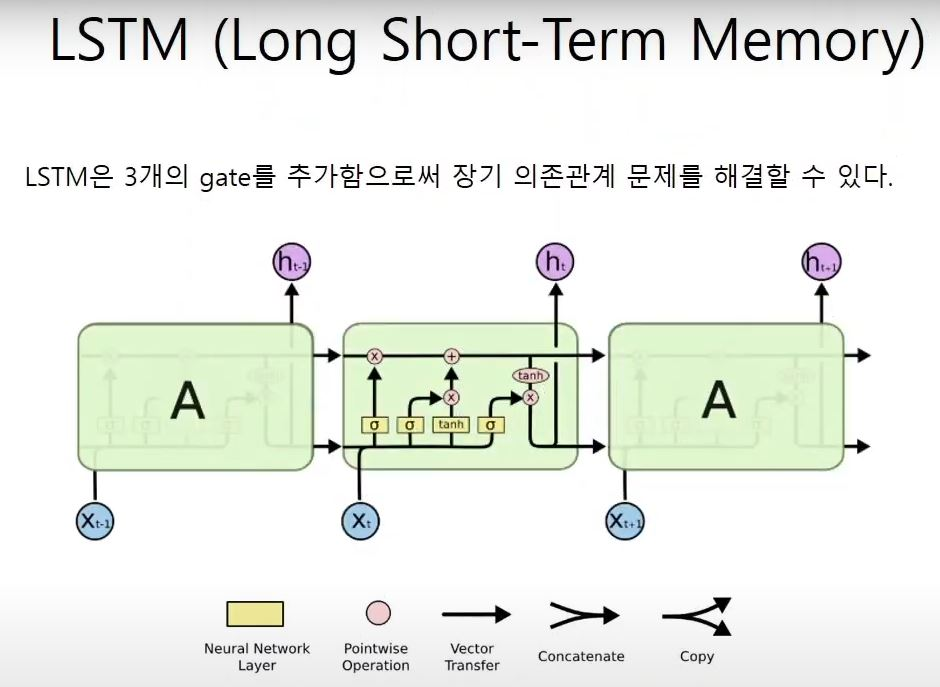
<br>
`Hyperbolic Tangent Function` $\rightarrow$ **Information** <br>
`Sigmoid Function` $\rightarrow$ **By how much information** do I use

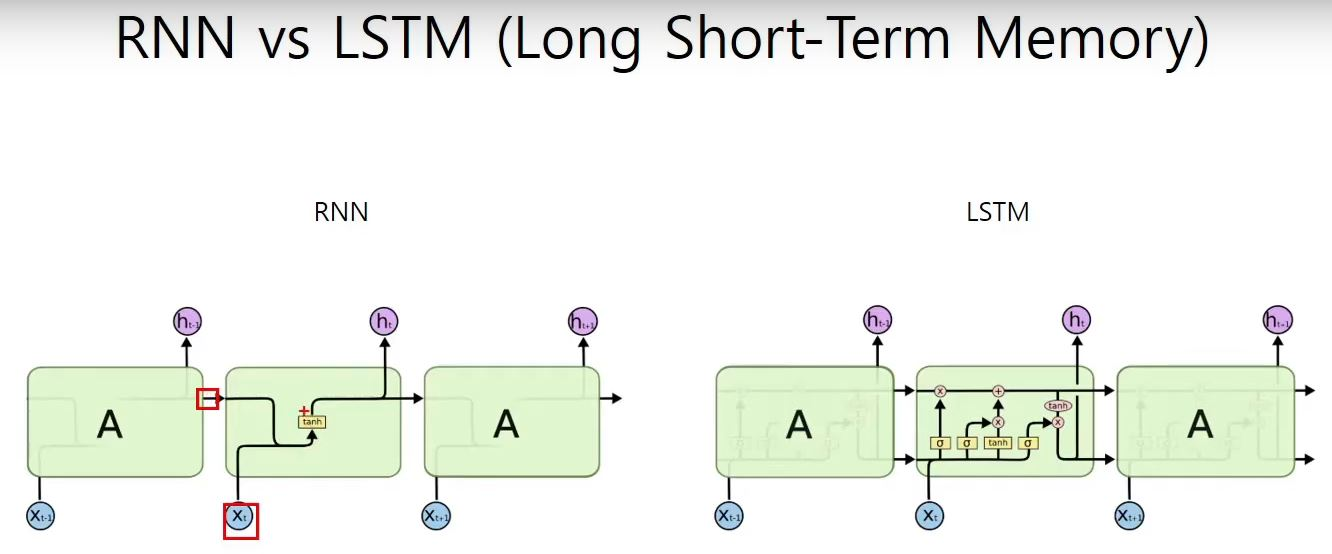

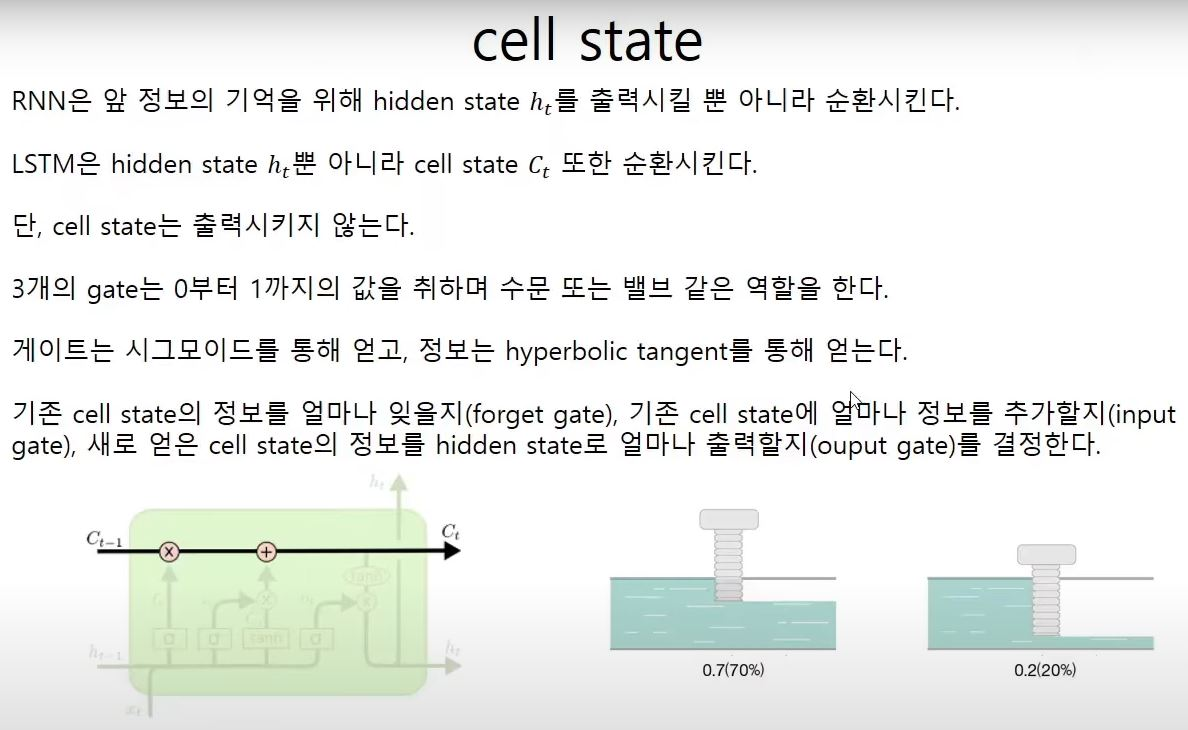

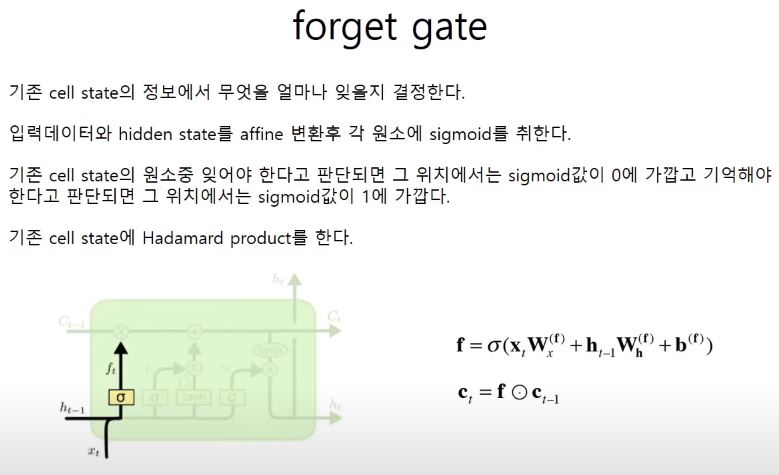
<br>
Typo:
$C_t = f \odot C_{t-1} \rightarrow f \odot C_{t-1}$

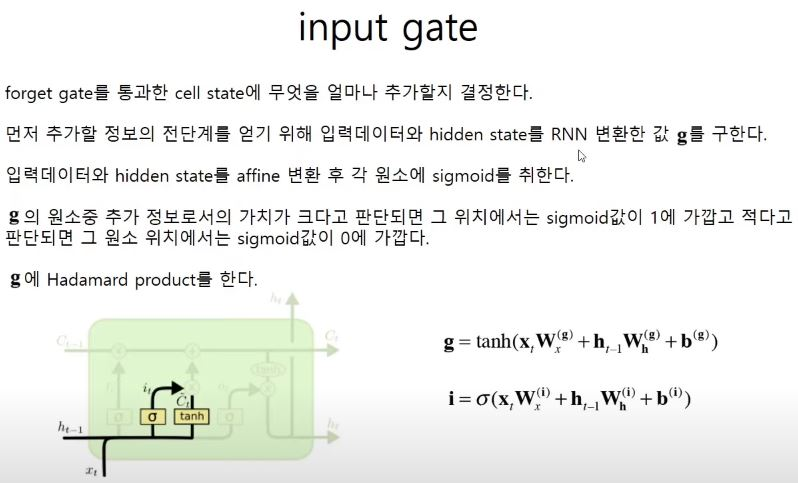

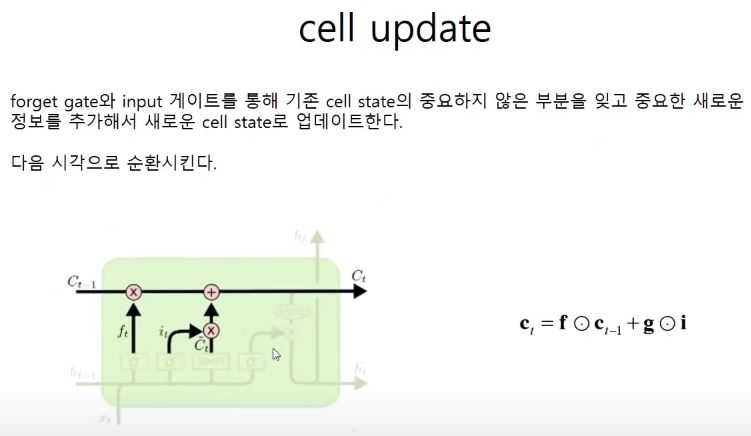

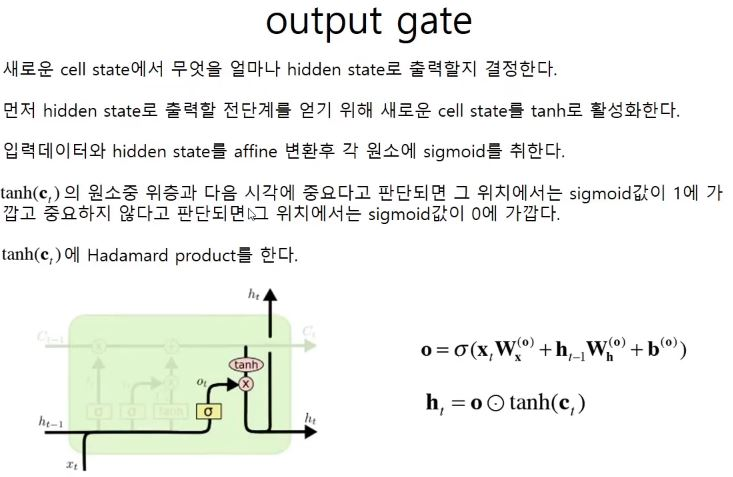

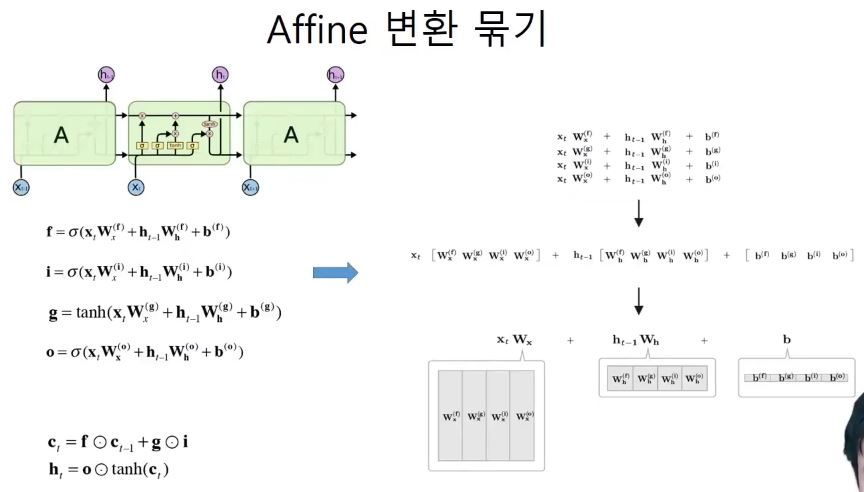

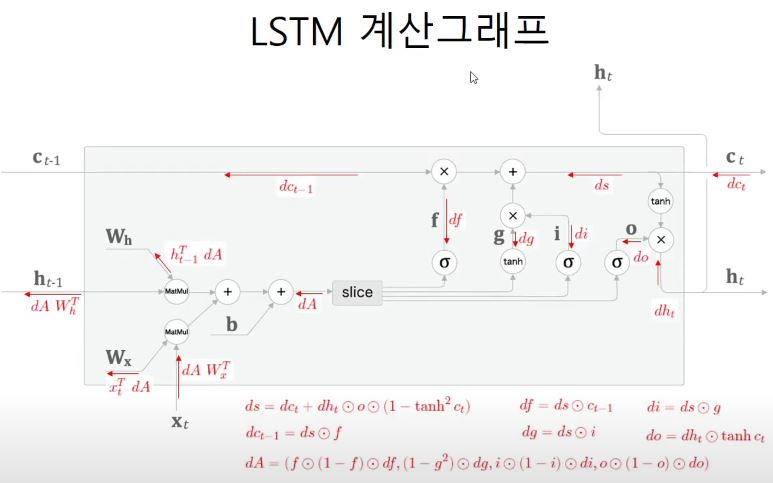
<br>
slice: just like the shape in the shaded area in the above cell

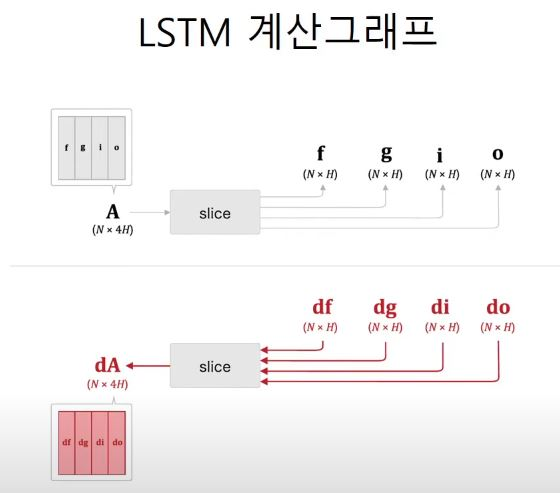

In [21]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [77]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        # c_prev: cell state from the previous layer
        Wx, Wh, b = self.params
        N, H = h_prev.shape # Note that the dimensionality
                            # of the cell state data and
                            # the dimensionality of the hidden state data (H)
                            # are the same.
        
        # Affine transformation
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2 * H]
        i = A[:, 2 * H: 3 * H]
        o = A[:, 3 * H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        
        dc_prev = ds * f # cell state back prop
        df = ds * dc_prev # forget gate back prop
        di = ds * g # input gate back prop
        dg = ds * i
        do = dh_next * tanh_c_next # output gate back prop
        
        df *= f * (1 - f)
        di *= i * (1 - i)
        dg *= (1 - g ** 2)
        do *= o * (1 - o)
        
        dA = np.hstack((df, dg, di, do))
        dWx = np.dot(x.T, dA)
        dWh = np.dot(h_prev.T, dA)
        db = dA.sum(axis = 0) # axis 0: batch size
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

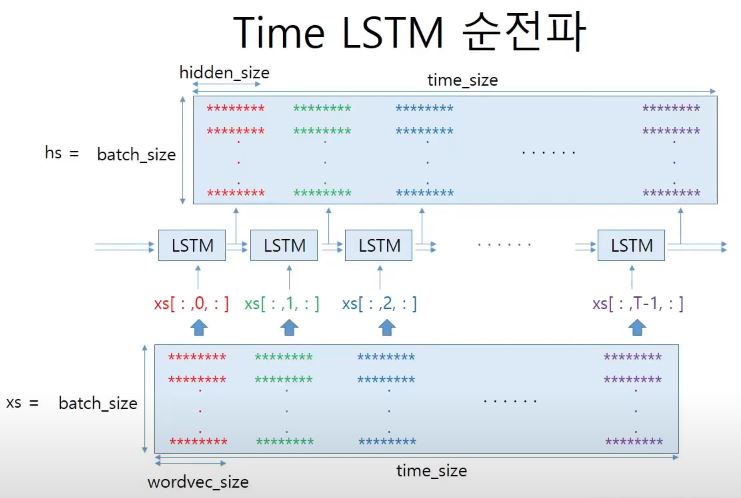

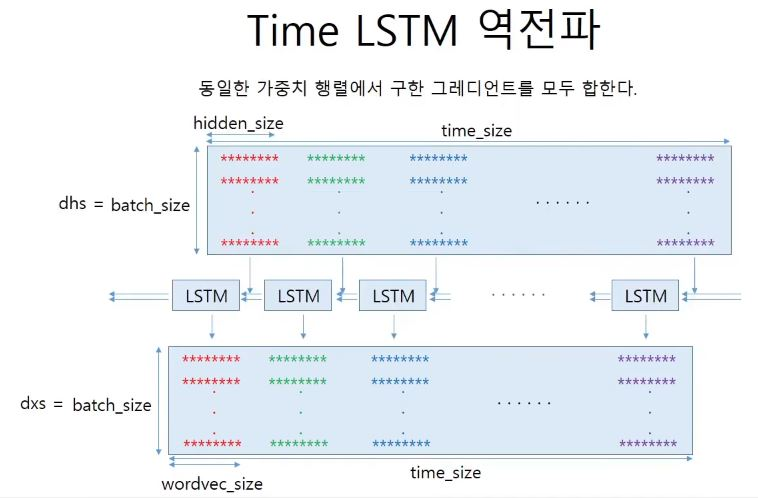

In [78]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype = 'f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype = 'f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape # dhs: N X T X H
        D = Wx.shape[0] # Wx: D X H
        
        dxs = np.empty((N, T, D), dtype = 'f')
        dh, dc = 0, 0 # You do not have to designate the detailed
                      # dimensionality and shape
                      # because broadcasting will be applied
                      # in the following code.
        
        grads = [0, 0, 0] # dWx, dWh, db
                          # You do not have to designate the detailed
                          # dimensionality and shape
                          # because broadcasting will be applied
                          # in the following code.
        for t in reversed(range(T)):
            layer = self.layers[t]
            # LSTM.backward(self, dh_next, dc_next)
            # dhs[:, t, :] + dh -> dh_next
            # from the loss function at t -> dhs[:, t, :]
            # from the previous LSTM layer -> dh
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad # in order of dWx, dWh, db
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh # redundant line
                     # necessary unless truncated BPTT
        
        return dxs
    
    def set_state(self, h, c = None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None

In [79]:
import os

In [80]:
class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None
        
    def forward(self, *args):
        raise NotImplementedError
        
    def backward(self, *args):
        raise NotImplementedError
        
    def save_params(self, file_name = None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'
            
        params = [p.astype(np.float16) for p in self.params]
        
        if GPU:
            params = [to_cpu(p) for p in params]
        
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
            
    def load_params(self, file_name = None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'
            
        if '/' in file_name:
            file_name = file_name.replace('/', os.sep) # os.sep: '\\'
        
        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)
            
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
            
        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]
            
        for i, param in enumerate(self.params):
            param[...] = params[i] # deep copy to self.params

In [81]:
class RNNLM(BaseModel):
    def __init__(self, vocab_size = 10000, wordvec_size = 100,
                 hidden_size = 100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # weights initialization
        embed_W = (rn(V, D) / 100).astype('f')
        # 4 * H -> There are 4 gates in the LSTM layer.
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') # dividing by np.sqrt(D)
                                                          # -> LeCun initialization
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # creating layers
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftMaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
            
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        
        return loss
    
    def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()

In [90]:
# hyperparameters
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25 # for gradient clipping
GPU = False

In [83]:
# input data
train, val, test = chainer.datasets.get_ptb_words()
# corpus
corpus = train
corpus_test = test
word_to_id = chainer.datasets.get_ptb_words_vocabulary()
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [84]:
# model instantiation
model = RNNLM(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RNNLMTrainer(model, optimizer)

Epoch: 1
Iteration: the 1th out of 1327
Elapsed Time: 0.22005391120910645
Perplexity: 10000.06
Epoch: 1
Iteration: the 21th out of 1327
Elapsed Time: 4.8452534675598145
Perplexity: 2679.58
Epoch: 1
Iteration: the 41th out of 1327
Elapsed Time: 9.426853656768799
Perplexity: 1205.83
Epoch: 1
Iteration: the 61th out of 1327
Elapsed Time: 13.907894372940063
Perplexity: 968.61
Epoch: 1
Iteration: the 81th out of 1327
Elapsed Time: 18.399762392044067
Perplexity: 792.97
Epoch: 1
Iteration: the 101th out of 1327
Elapsed Time: 22.98958992958069
Perplexity: 660.25
Epoch: 1
Iteration: the 121th out of 1327
Elapsed Time: 27.583021640777588
Perplexity: 659.45
Epoch: 1
Iteration: the 141th out of 1327
Elapsed Time: 32.0528130531311
Perplexity: 592.31
Epoch: 1
Iteration: the 161th out of 1327
Elapsed Time: 36.49587559700012
Perplexity: 577.70
Epoch: 1
Iteration: the 181th out of 1327
Elapsed Time: 41.03163123130798
Perplexity: 611.18
Epoch: 1
Iteration: the 201th out of 1327
Elapsed Time: 45.57525730

Epoch: 2
Iteration: the 421th out of 1327
Elapsed Time: 391.2172381877899
Perplexity: 167.38
Epoch: 2
Iteration: the 441th out of 1327
Elapsed Time: 395.43778705596924
Perplexity: 175.61
Epoch: 2
Iteration: the 461th out of 1327
Elapsed Time: 399.68119072914124
Perplexity: 167.94
Epoch: 2
Iteration: the 481th out of 1327
Elapsed Time: 403.90529894828796
Perplexity: 168.50
Epoch: 2
Iteration: the 501th out of 1327
Elapsed Time: 408.1256408691406
Perplexity: 182.79
Epoch: 2
Iteration: the 521th out of 1327
Elapsed Time: 412.3445737361908
Perplexity: 184.34
Epoch: 2
Iteration: the 541th out of 1327
Elapsed Time: 416.77711176872253
Perplexity: 186.44
Epoch: 2
Iteration: the 561th out of 1327
Elapsed Time: 421.1679103374481
Perplexity: 167.80
Epoch: 2
Iteration: the 581th out of 1327
Elapsed Time: 425.4642069339752
Perplexity: 148.98
Epoch: 2
Iteration: the 601th out of 1327
Elapsed Time: 429.75875782966614
Perplexity: 202.72
Epoch: 2
Iteration: the 621th out of 1327
Elapsed Time: 434.01572

Epoch: 3
Iteration: the 841th out of 1327
Elapsed Time: 763.4981079101562
Perplexity: 126.93
Epoch: 3
Iteration: the 861th out of 1327
Elapsed Time: 767.6730453968048
Perplexity: 133.50
Epoch: 3
Iteration: the 881th out of 1327
Elapsed Time: 771.8177754878998
Perplexity: 121.49
Epoch: 3
Iteration: the 901th out of 1327
Elapsed Time: 775.9897067546844
Perplexity: 147.51
Epoch: 3
Iteration: the 921th out of 1327
Elapsed Time: 780.1656496524811
Perplexity: 135.71
Epoch: 3
Iteration: the 941th out of 1327
Elapsed Time: 784.3285887241364
Perplexity: 142.06
Epoch: 3
Iteration: the 961th out of 1327
Elapsed Time: 788.4955265522003
Perplexity: 147.93
Epoch: 3
Iteration: the 981th out of 1327
Elapsed Time: 792.6834847927094
Perplexity: 138.97
Epoch: 3
Iteration: the 1001th out of 1327
Elapsed Time: 796.8544101715088
Perplexity: 121.68
Epoch: 3
Iteration: the 1021th out of 1327
Elapsed Time: 801.0183501243591
Perplexity: 141.05
Epoch: 3
Iteration: the 1041th out of 1327
Elapsed Time: 805.2012922

Epoch: 4
Iteration: the 1261th out of 1327
Elapsed Time: 1128.9934799671173
Perplexity: 110.90
Epoch: 4
Iteration: the 1281th out of 1327
Elapsed Time: 1133.137413263321
Perplexity: 106.58
Epoch: 4
Iteration: the 1301th out of 1327
Elapsed Time: 1137.2973442077637
Perplexity: 131.58
Epoch: 4
Iteration: the 1321th out of 1327
Elapsed Time: 1141.4732716083527
Perplexity: 129.55


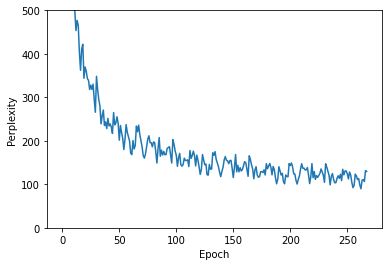

In [85]:
trainer.training(xs, ts, max_epoch, batch_size, time_size, max_grad,
                 eval_interval = 20)
trainer.plot(ylim = (0, 500))

In [86]:
import sys

In [87]:
def eval_perplexity(model, corpus, batch_size = 10, time_size = 35):
    print('Evaluating perplexity ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype = np.int32)
        ts = np.zeros((batch_size, time_size), dtype = np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg = False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters + 1, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    
    return ppl

In [88]:
# model evaluation
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('Test Perplexity: ', ppl_test)

Evaluating perplexity ...
234 / 235
Test Perplexity:  150.51212027723258


In [92]:
import pickle

In [93]:
# storing parameters
model.save_params()

# Improving RNN Language Models
---

Improving RNNLM: Multi-layer

Improving RNNLM: Dropout

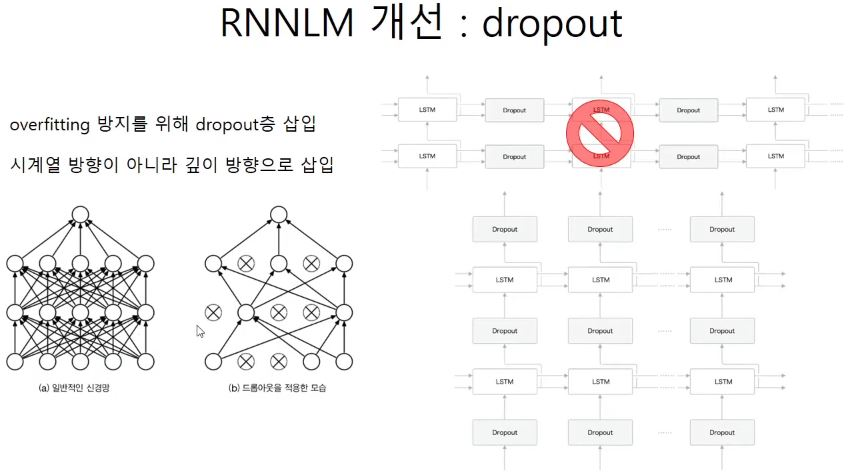

In [110]:
class TimeDropout:
    def __init__(self, dropout_ratio = 0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True
        
    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            # scaling
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale
            
            return xs * self.mask
        else:
            return xs
        
    def backward(self, dout):
        return dout * self.mask

Improving RNNLM: Weight Tying
- Refer to the following paper.
- https://arxiv.org/pdf/1608.05859v3.pdf
    - p. 5 $\rightarrow\$ As can be seen in Tab. 5, weight tying significantly reduces perplexity on both the validation set and the test set, but not on the training set. This indicates less overfitting, as expected due to the reduction in the number of parameters.
- Weight Tying can contribute to alleviating overfitting problems by reducing the number of parameters.

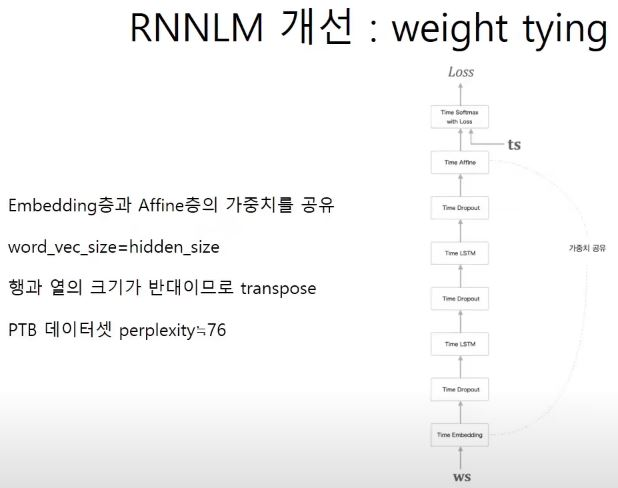

In [111]:
class BetterRNNLM(BaseModel):
    """
    Two LSTM layers
    Dropout applied
    Weight Tying
    
    < References >
    [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
    [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
    [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    """
    # wordvec_size and hidden_size must be the same! -> Weight Tying
    def __init__(self, vocab_size = 10000, wordvec_size = 650,
                 hidden_size = 650, dropout_ratio = 0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f') # affine_W <- transpose of embed_W
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful = True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful = True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # Weight Tying
        ]
        self.loss_layer = TimeSoftMaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads =  [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flg = False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
            
        for layer in self.layers:
            xs = layer.forward(xs)
        
        return xs
    
    def forward(self, xs, ts, train_flg = True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        
        return loss
    
    def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [112]:
# hyperparameters
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5
GPU = False

In [113]:
# input data
train, val, test = chainer.datasets.get_ptb_words()
# corpus
corpus = train
corpus_test = test
word_to_id = chainer.datasets.get_ptb_words_vocabulary()
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [114]:
model = BetterRNNLM(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RNNLMTrainer(model, optimizer)

In [115]:
best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.training(xs, ts, max_epoch = 1, batch_size = batch_size,
                     time_size = time_size, max_grad = max_grad)
    
    model.reset_state()
    ppl = eval_perplexity(model, corpus_test)
    print("Evaluation Perplexity: ", ppl)
    
    # Start with a learning rate which is large enough. (ex) lr = 20.0)
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
        
    model.reset_state()
    print('-' * 50)

Epoch: 1
Iteration: the 1th out of 1327
Elapsed Time: 1.9014370441436768
Perplexity: 10000.24
Epoch: 1
Iteration: the 21th out of 1327
Elapsed Time: 41.4132924079895
Perplexity: 4059.39
Epoch: 1
Iteration: the 41th out of 1327
Elapsed Time: 80.73131990432739
Perplexity: 1791.77
Epoch: 1
Iteration: the 61th out of 1327
Elapsed Time: 119.89770078659058
Perplexity: 1390.77
Epoch: 1
Iteration: the 81th out of 1327
Elapsed Time: 159.36244368553162
Perplexity: 1121.84
Epoch: 1
Iteration: the 101th out of 1327
Elapsed Time: 199.40627026557922
Perplexity: 938.75
Epoch: 1
Iteration: the 121th out of 1327
Elapsed Time: 238.80799198150635
Perplexity: 886.29
Epoch: 1
Iteration: the 141th out of 1327
Elapsed Time: 278.4980592727661
Perplexity: 744.02
Epoch: 1
Iteration: the 161th out of 1327
Elapsed Time: 318.5013358592987
Perplexity: 724.55
Epoch: 1
Iteration: the 181th out of 1327
Elapsed Time: 358.77110743522644
Perplexity: 697.55
Epoch: 1
Iteration: the 201th out of 1327
Elapsed Time: 397.50485

Epoch: 2
Iteration: the 401th out of 1327
Elapsed Time: 758.953652381897
Perplexity: 203.26
Epoch: 2
Iteration: the 421th out of 1327
Elapsed Time: 796.806494474411
Perplexity: 185.78
Epoch: 2
Iteration: the 441th out of 1327
Elapsed Time: 834.7110242843628
Perplexity: 187.98
Epoch: 2
Iteration: the 461th out of 1327
Elapsed Time: 872.6407113075256
Perplexity: 190.71
Epoch: 2
Iteration: the 481th out of 1327
Elapsed Time: 910.5073726177216
Perplexity: 183.38
Epoch: 2
Iteration: the 501th out of 1327
Elapsed Time: 948.397748708725
Perplexity: 197.85
Epoch: 2
Iteration: the 521th out of 1327
Elapsed Time: 986.2115578651428
Perplexity: 198.99
Epoch: 2
Iteration: the 541th out of 1327
Elapsed Time: 1024.179414987564
Perplexity: 209.93
Epoch: 2
Iteration: the 561th out of 1327
Elapsed Time: 1062.0829544067383
Perplexity: 180.23
Epoch: 2
Iteration: the 581th out of 1327
Elapsed Time: 1100.060527086258
Perplexity: 166.63
Epoch: 2
Iteration: the 601th out of 1327
Elapsed Time: 1137.94128346443

Epoch: 3
Iteration: the 801th out of 1327
Elapsed Time: 1521.2137534618378
Perplexity: 144.22
Epoch: 3
Iteration: the 821th out of 1327
Elapsed Time: 1559.1903867721558
Perplexity: 140.31
Epoch: 3
Iteration: the 841th out of 1327
Elapsed Time: 1597.1480340957642
Perplexity: 141.49
Epoch: 3
Iteration: the 861th out of 1327
Elapsed Time: 1634.9305257797241
Perplexity: 138.58
Epoch: 3
Iteration: the 881th out of 1327
Elapsed Time: 1672.8733491897583
Perplexity: 127.45
Epoch: 3
Iteration: the 901th out of 1327
Elapsed Time: 1710.7278764247894
Perplexity: 159.60
Epoch: 3
Iteration: the 921th out of 1327
Elapsed Time: 1748.7902846336365
Perplexity: 143.83
Epoch: 3
Iteration: the 941th out of 1327
Elapsed Time: 1786.8769104480743
Perplexity: 148.55
Epoch: 3
Iteration: the 961th out of 1327
Elapsed Time: 1824.757738828659
Perplexity: 159.90
Epoch: 3
Iteration: the 981th out of 1327
Elapsed Time: 1862.7043106555939
Perplexity: 151.70
Epoch: 3
Iteration: the 1001th out of 1327
Elapsed Time: 1900

Epoch: 4
Iteration: the 1201th out of 1327
Elapsed Time: 2275.7809410095215
Perplexity: 95.72
Epoch: 4
Iteration: the 1221th out of 1327
Elapsed Time: 2314.680242061615
Perplexity: 97.25
Epoch: 4
Iteration: the 1241th out of 1327
Elapsed Time: 2352.6811316013336
Perplexity: 116.61
Epoch: 4
Iteration: the 1261th out of 1327
Elapsed Time: 2390.6115453243256
Perplexity: 109.63
Epoch: 4
Iteration: the 1281th out of 1327
Elapsed Time: 2428.476809024811
Perplexity: 110.08
Epoch: 4
Iteration: the 1301th out of 1327
Elapsed Time: 2466.3614835739136
Perplexity: 140.16
Epoch: 4
Iteration: the 1321th out of 1327
Elapsed Time: 2504.2280361652374
Perplexity: 136.13
Evaluating perplexity ...
234 / 235
Evaluation Perplexity:  117.74767894747416
--------------------------------------------------
Epoch: 5
Iteration: the 1th out of 1327
Elapsed Time: 1.9044373035430908
Perplexity: 177.25
Epoch: 5
Iteration: the 21th out of 1327
Elapsed Time: 40.089945793151855
Perplexity: 123.13
Epoch: 5
Iteration: the 

Epoch: 6
Iteration: the 221th out of 1327
Elapsed Time: 420.33154678344727
Perplexity: 120.10
Epoch: 6
Iteration: the 241th out of 1327
Elapsed Time: 458.5599727630615
Perplexity: 113.72
Epoch: 6
Iteration: the 261th out of 1327
Elapsed Time: 496.6175570487976
Perplexity: 122.62
Epoch: 6
Iteration: the 281th out of 1327
Elapsed Time: 534.7131397724152
Perplexity: 120.20
Epoch: 6
Iteration: the 301th out of 1327
Elapsed Time: 572.7857255935669
Perplexity: 100.12
Epoch: 6
Iteration: the 321th out of 1327
Elapsed Time: 610.8037168979645
Perplexity: 80.24
Epoch: 6
Iteration: the 341th out of 1327
Elapsed Time: 648.699254989624
Perplexity: 113.92
Epoch: 6
Iteration: the 361th out of 1327
Elapsed Time: 686.7780153751373
Perplexity: 121.01
Epoch: 6
Iteration: the 381th out of 1327
Elapsed Time: 724.9486014842987
Perplexity: 99.86
Epoch: 6
Iteration: the 401th out of 1327
Elapsed Time: 762.8672077655792
Perplexity: 111.25
Epoch: 6
Iteration: the 421th out of 1327
Elapsed Time: 800.756959915161

Epoch: 7
Iteration: the 621th out of 1327
Elapsed Time: 1180.5160958766937
Perplexity: 115.80
Epoch: 7
Iteration: the 641th out of 1327
Elapsed Time: 1218.714641571045
Perplexity: 105.95
Epoch: 7
Iteration: the 661th out of 1327
Elapsed Time: 1256.8252387046814
Perplexity: 98.52
Epoch: 7
Iteration: the 681th out of 1327
Elapsed Time: 1294.898992061615
Perplexity: 84.13
Epoch: 7
Iteration: the 701th out of 1327
Elapsed Time: 1333.0107908248901
Perplexity: 100.31
Epoch: 7
Iteration: the 721th out of 1327
Elapsed Time: 1371.1878097057343
Perplexity: 101.87
Epoch: 7
Iteration: the 741th out of 1327
Elapsed Time: 1409.242747783661
Perplexity: 90.31
Epoch: 7
Iteration: the 761th out of 1327
Elapsed Time: 1447.308622598648
Perplexity: 81.25
Epoch: 7
Iteration: the 781th out of 1327
Elapsed Time: 1485.3663263320923
Perplexity: 88.83
Epoch: 7
Iteration: the 801th out of 1327
Elapsed Time: 1523.4669404029846
Perplexity: 101.99
Epoch: 7
Iteration: the 821th out of 1327
Elapsed Time: 1561.48660182

Epoch: 8
Iteration: the 1021th out of 1327
Elapsed Time: 1952.9043781757355
Perplexity: 106.31
Epoch: 8
Iteration: the 1041th out of 1327
Elapsed Time: 1991.128787279129
Perplexity: 92.21
Epoch: 8
Iteration: the 1061th out of 1327
Elapsed Time: 2029.30512881279
Perplexity: 86.98
Epoch: 8
Iteration: the 1081th out of 1327
Elapsed Time: 2067.5077855587006
Perplexity: 72.81
Epoch: 8
Iteration: the 1101th out of 1327
Elapsed Time: 2105.6927332878113
Perplexity: 74.76
Epoch: 8
Iteration: the 1121th out of 1327
Elapsed Time: 2143.98349070549
Perplexity: 101.07
Epoch: 8
Iteration: the 1141th out of 1327
Elapsed Time: 2182.3352460861206
Perplexity: 99.60
Epoch: 8
Iteration: the 1161th out of 1327
Elapsed Time: 2221.0799701213837
Perplexity: 82.62
Epoch: 8
Iteration: the 1181th out of 1327
Elapsed Time: 2259.31028676033
Perplexity: 90.81
Epoch: 8
Iteration: the 1201th out of 1327
Elapsed Time: 2297.6288163661957
Perplexity: 76.23
Epoch: 8
Iteration: the 1221th out of 1327
Elapsed Time: 2336.004

Epoch: 10
Iteration: the 61th out of 1327
Elapsed Time: 118.87384176254272
Perplexity: 86.87
Epoch: 10
Iteration: the 81th out of 1327
Elapsed Time: 157.7223346233368
Perplexity: 75.06
Epoch: 10
Iteration: the 101th out of 1327
Elapsed Time: 196.61216759681702
Perplexity: 74.06
Epoch: 10
Iteration: the 121th out of 1327
Elapsed Time: 235.47826385498047
Perplexity: 79.19
Epoch: 10
Iteration: the 141th out of 1327
Elapsed Time: 274.277783870697
Perplexity: 85.82
Epoch: 10
Iteration: the 161th out of 1327
Elapsed Time: 312.68566250801086
Perplexity: 100.27
Epoch: 10
Iteration: the 181th out of 1327
Elapsed Time: 350.93399691581726
Perplexity: 105.27
Epoch: 10
Iteration: the 201th out of 1327
Elapsed Time: 389.1645736694336
Perplexity: 103.22
Epoch: 10
Iteration: the 221th out of 1327
Elapsed Time: 427.40246772766113
Perplexity: 99.67
Epoch: 10
Iteration: the 241th out of 1327
Elapsed Time: 465.70624232292175
Perplexity: 94.76
Epoch: 10
Iteration: the 261th out of 1327
Elapsed Time: 503.96

Epoch: 11
Iteration: the 461th out of 1327
Elapsed Time: 882.7323782444
Perplexity: 84.94
Epoch: 11
Iteration: the 481th out of 1327
Elapsed Time: 921.0831620693207
Perplexity: 84.33
Epoch: 11
Iteration: the 501th out of 1327
Elapsed Time: 959.5369668006897
Perplexity: 93.62
Epoch: 11
Iteration: the 521th out of 1327
Elapsed Time: 997.8427572250366
Perplexity: 95.12
Epoch: 11
Iteration: the 541th out of 1327
Elapsed Time: 1036.1645212173462
Perplexity: 96.82
Epoch: 11
Iteration: the 561th out of 1327
Elapsed Time: 1074.5941729545593
Perplexity: 81.16
Epoch: 11
Iteration: the 581th out of 1327
Elapsed Time: 1112.9989392757416
Perplexity: 74.72
Epoch: 11
Iteration: the 601th out of 1327
Elapsed Time: 1151.3606822490692
Perplexity: 105.39
Epoch: 11
Iteration: the 621th out of 1327
Elapsed Time: 1189.7571105957031
Perplexity: 99.11
Epoch: 11
Iteration: the 641th out of 1327
Elapsed Time: 1228.1671388149261
Perplexity: 91.52
Epoch: 11
Iteration: the 661th out of 1327
Elapsed Time: 1266.6585

Epoch: 12
Iteration: the 861th out of 1327
Elapsed Time: 1648.5283274650574
Perplexity: 83.94
Epoch: 12
Iteration: the 881th out of 1327
Elapsed Time: 1686.7549967765808
Perplexity: 76.53
Epoch: 12
Iteration: the 901th out of 1327
Elapsed Time: 1725.0171279907227
Perplexity: 96.77
Epoch: 12
Iteration: the 921th out of 1327
Elapsed Time: 1763.40886759758
Perplexity: 85.23
Epoch: 12
Iteration: the 941th out of 1327
Elapsed Time: 1801.771544456482
Perplexity: 91.48
Epoch: 12
Iteration: the 961th out of 1327
Elapsed Time: 1840.0945785045624
Perplexity: 99.05
Epoch: 12
Iteration: the 981th out of 1327
Elapsed Time: 1878.5613515377045
Perplexity: 92.95
Epoch: 12
Iteration: the 1001th out of 1327
Elapsed Time: 1916.999989271164
Perplexity: 80.97
Epoch: 12
Iteration: the 1021th out of 1327
Elapsed Time: 1955.3280930519104
Perplexity: 95.65
Epoch: 12
Iteration: the 1041th out of 1327
Elapsed Time: 1993.4808089733124
Perplexity: 81.04
Epoch: 12
Iteration: the 1061th out of 1327
Elapsed Time: 203

Epoch: 13
Iteration: the 1261th out of 1327
Elapsed Time: 2427.038279056549
Perplexity: 75.58
Epoch: 13
Iteration: the 1281th out of 1327
Elapsed Time: 2465.8175179958344
Perplexity: 75.89
Epoch: 13
Iteration: the 1301th out of 1327
Elapsed Time: 2504.497498035431
Perplexity: 94.80
Epoch: 13
Iteration: the 1321th out of 1327
Elapsed Time: 2543.2002182006836
Perplexity: 92.72
Evaluating perplexity ...
234 / 235
Evaluation Perplexity:  94.99519091234968
--------------------------------------------------
Epoch: 14
Iteration: the 1th out of 1327
Elapsed Time: 1.953425407409668
Perplexity: 127.40
Epoch: 14
Iteration: the 21th out of 1327
Elapsed Time: 40.897748947143555
Perplexity: 83.18
Epoch: 14
Iteration: the 41th out of 1327
Elapsed Time: 79.61455082893372
Perplexity: 81.25
Epoch: 14
Iteration: the 61th out of 1327
Elapsed Time: 118.34234666824341
Perplexity: 77.60
Epoch: 14
Iteration: the 81th out of 1327
Elapsed Time: 157.02538681030273
Perplexity: 68.80
Epoch: 14
Iteration: the 101th

Epoch: 15
Iteration: the 281th out of 1327
Elapsed Time: 538.8698449134827
Perplexity: 89.88
Epoch: 15
Iteration: the 301th out of 1327
Elapsed Time: 577.6665232181549
Perplexity: 73.04
Epoch: 15
Iteration: the 321th out of 1327
Elapsed Time: 616.370484828949
Perplexity: 58.85
Epoch: 15
Iteration: the 341th out of 1327
Elapsed Time: 655.1362357139587
Perplexity: 84.46
Epoch: 15
Iteration: the 361th out of 1327
Elapsed Time: 694.055935382843
Perplexity: 88.97
Epoch: 15
Iteration: the 381th out of 1327
Elapsed Time: 732.8529586791992
Perplexity: 75.12
Epoch: 15
Iteration: the 401th out of 1327
Elapsed Time: 771.7335557937622
Perplexity: 84.31
Epoch: 15
Iteration: the 421th out of 1327
Elapsed Time: 810.5853836536407
Perplexity: 72.74
Epoch: 15
Iteration: the 441th out of 1327
Elapsed Time: 849.4162211418152
Perplexity: 77.79
Epoch: 15
Iteration: the 461th out of 1327
Elapsed Time: 888.2730491161346
Perplexity: 78.33
Epoch: 15
Iteration: the 481th out of 1327
Elapsed Time: 927.23595976829

Epoch: 16
Iteration: the 681th out of 1327
Elapsed Time: 1339.1535029411316
Perplexity: 66.74
Epoch: 16
Iteration: the 701th out of 1327
Elapsed Time: 1378.724842786789
Perplexity: 79.79
Epoch: 16
Iteration: the 721th out of 1327
Elapsed Time: 1418.1689109802246
Perplexity: 78.67
Epoch: 16
Iteration: the 741th out of 1327
Elapsed Time: 1457.8153421878815
Perplexity: 70.80
Epoch: 16
Iteration: the 761th out of 1327
Elapsed Time: 1497.1122918128967
Perplexity: 64.11
Epoch: 16
Iteration: the 781th out of 1327
Elapsed Time: 1536.3605279922485
Perplexity: 69.54
Epoch: 16
Iteration: the 801th out of 1327
Elapsed Time: 1575.620440006256
Perplexity: 78.41
Epoch: 16
Iteration: the 821th out of 1327
Elapsed Time: 1614.8769884109497
Perplexity: 82.39
Epoch: 16
Iteration: the 841th out of 1327
Elapsed Time: 1654.1068959236145
Perplexity: 80.74
Epoch: 16
Iteration: the 861th out of 1327
Elapsed Time: 1693.919592142105
Perplexity: 79.15
Epoch: 16
Iteration: the 881th out of 1327
Elapsed Time: 1734.3

Epoch: 17
Iteration: the 1081th out of 1327
Elapsed Time: 2128.8001680374146
Perplexity: 60.10
Epoch: 17
Iteration: the 1101th out of 1327
Elapsed Time: 2168.075131893158
Perplexity: 61.65
Epoch: 17
Iteration: the 1121th out of 1327
Elapsed Time: 2207.2321050167084
Perplexity: 84.90
Epoch: 17
Iteration: the 1141th out of 1327
Elapsed Time: 2246.544912815094
Perplexity: 80.69
Epoch: 17
Iteration: the 1161th out of 1327
Elapsed Time: 2285.929817199707
Perplexity: 67.71
Epoch: 17
Iteration: the 1181th out of 1327
Elapsed Time: 2325.1214656829834
Perplexity: 76.93
Epoch: 17
Iteration: the 1201th out of 1327
Elapsed Time: 2364.292459487915
Perplexity: 62.92
Epoch: 17
Iteration: the 1221th out of 1327
Elapsed Time: 2403.502073764801
Perplexity: 61.33
Epoch: 17
Iteration: the 1241th out of 1327
Elapsed Time: 2442.8303139209747
Perplexity: 73.76
Epoch: 17
Iteration: the 1261th out of 1327
Elapsed Time: 2482.0751526355743
Perplexity: 72.11
Epoch: 17
Iteration: the 1281th out of 1327
Elapsed Tim

Epoch: 19
Iteration: the 101th out of 1327
Elapsed Time: 197.71880316734314
Perplexity: 62.65
Epoch: 19
Iteration: the 121th out of 1327
Elapsed Time: 236.99078273773193
Perplexity: 66.09
Epoch: 19
Iteration: the 141th out of 1327
Elapsed Time: 276.2359690666199
Perplexity: 71.28
Epoch: 19
Iteration: the 161th out of 1327
Elapsed Time: 315.24897599220276
Perplexity: 83.36
Epoch: 19
Iteration: the 181th out of 1327
Elapsed Time: 354.29834747314453
Perplexity: 87.03
Epoch: 19
Iteration: the 201th out of 1327
Elapsed Time: 393.757337808609
Perplexity: 84.18
Epoch: 19
Iteration: the 221th out of 1327
Elapsed Time: 433.3577125072479
Perplexity: 81.81
Epoch: 19
Iteration: the 241th out of 1327
Elapsed Time: 471.85127115249634
Perplexity: 77.07
Epoch: 19
Iteration: the 261th out of 1327
Elapsed Time: 511.0701563358307
Perplexity: 83.09
Epoch: 19
Iteration: the 281th out of 1327
Elapsed Time: 550.1149084568024
Perplexity: 81.48
Epoch: 19
Iteration: the 301th out of 1327
Elapsed Time: 588.94010

Epoch: 20
Iteration: the 501th out of 1327
Elapsed Time: 959.3921213150024
Perplexity: 70.21
Epoch: 20
Iteration: the 521th out of 1327
Elapsed Time: 996.8374681472778
Perplexity: 73.70
Epoch: 20
Iteration: the 541th out of 1327
Elapsed Time: 1034.3440155982971
Perplexity: 74.34
Epoch: 20
Iteration: the 561th out of 1327
Elapsed Time: 1071.7675948143005
Perplexity: 62.25
Epoch: 20
Iteration: the 581th out of 1327
Elapsed Time: 1109.9348468780518
Perplexity: 58.03
Epoch: 20
Iteration: the 601th out of 1327
Elapsed Time: 1147.7890527248383
Perplexity: 83.89
Epoch: 20
Iteration: the 621th out of 1327
Elapsed Time: 1185.2236552238464
Perplexity: 76.25
Epoch: 20
Iteration: the 641th out of 1327
Elapsed Time: 1222.6101157665253
Perplexity: 69.58
Epoch: 20
Iteration: the 661th out of 1327
Elapsed Time: 1260.0465340614319
Perplexity: 63.10
Epoch: 20
Iteration: the 681th out of 1327
Elapsed Time: 1297.5227210521698
Perplexity: 55.07
Epoch: 20
Iteration: the 701th out of 1327
Elapsed Time: 1334.

Epoch: 21
Iteration: the 901th out of 1327
Elapsed Time: 1738.776291847229
Perplexity: 72.82
Epoch: 21
Iteration: the 921th out of 1327
Elapsed Time: 1777.8585822582245
Perplexity: 64.46
Epoch: 21
Iteration: the 941th out of 1327
Elapsed Time: 1815.6779420375824
Perplexity: 69.19
Epoch: 21
Iteration: the 961th out of 1327
Elapsed Time: 1853.317971944809
Perplexity: 74.40
Epoch: 21
Iteration: the 981th out of 1327
Elapsed Time: 1890.8545162677765
Perplexity: 70.68
Epoch: 21
Iteration: the 1001th out of 1327
Elapsed Time: 1928.324901342392
Perplexity: 60.06
Epoch: 21
Iteration: the 1021th out of 1327
Elapsed Time: 1965.8691802024841
Perplexity: 70.06
Epoch: 21
Iteration: the 1041th out of 1327
Elapsed Time: 2003.4335327148438
Perplexity: 60.20
Epoch: 21
Iteration: the 1061th out of 1327
Elapsed Time: 2041.5890321731567
Perplexity: 57.92
Epoch: 21
Iteration: the 1081th out of 1327
Elapsed Time: 2079.5575335025787
Perplexity: 47.58
Epoch: 21
Iteration: the 1101th out of 1327
Elapsed Time: 

Epoch: 22
Iteration: the 1281th out of 1327
Elapsed Time: 2416.359139442444
Perplexity: 55.88
Epoch: 22
Iteration: the 1301th out of 1327
Elapsed Time: 2453.579614162445
Perplexity: 69.32
Epoch: 22
Iteration: the 1321th out of 1327
Elapsed Time: 2490.310893058777
Perplexity: 68.50
Evaluating perplexity ...
234 / 235
Evaluation Perplexity:  86.12022278065737
--------------------------------------------------
Epoch: 23
Iteration: the 1th out of 1327
Elapsed Time: 1.8454020023345947
Perplexity: 92.37
Epoch: 23
Iteration: the 21th out of 1327
Elapsed Time: 38.68472385406494
Perplexity: 65.08
Epoch: 23
Iteration: the 41th out of 1327
Elapsed Time: 75.70806574821472
Perplexity: 62.82
Epoch: 23
Iteration: the 61th out of 1327
Elapsed Time: 112.52034282684326
Perplexity: 61.28
Epoch: 23
Iteration: the 81th out of 1327
Elapsed Time: 149.4156391620636
Perplexity: 52.56
Epoch: 23
Iteration: the 101th out of 1327
Elapsed Time: 186.19995260238647
Perplexity: 52.82
Epoch: 23
Iteration: the 121th out

Epoch: 24
Iteration: the 301th out of 1327
Elapsed Time: 569.0826370716095
Perplexity: 55.86
Epoch: 24
Iteration: the 321th out of 1327
Elapsed Time: 606.8991982936859
Perplexity: 45.13
Epoch: 24
Iteration: the 341th out of 1327
Elapsed Time: 644.6368021965027
Perplexity: 63.80
Epoch: 24
Iteration: the 361th out of 1327
Elapsed Time: 682.4861900806427
Perplexity: 65.64
Epoch: 24
Iteration: the 381th out of 1327
Elapsed Time: 720.4032671451569
Perplexity: 56.71
Epoch: 24
Iteration: the 401th out of 1327
Elapsed Time: 758.0297763347626
Perplexity: 64.46
Epoch: 24
Iteration: the 421th out of 1327
Elapsed Time: 795.7527904510498
Perplexity: 54.49
Epoch: 24
Iteration: the 441th out of 1327
Elapsed Time: 833.4873812198639
Perplexity: 58.70
Epoch: 24
Iteration: the 461th out of 1327
Elapsed Time: 871.2074692249298
Perplexity: 59.17
Epoch: 24
Iteration: the 481th out of 1327
Elapsed Time: 908.8020007610321
Perplexity: 58.67
Epoch: 24
Iteration: the 501th out of 1327
Elapsed Time: 946.514558076

Epoch: 25
Iteration: the 701th out of 1327
Elapsed Time: 1327.3752663135529
Perplexity: 59.96
Epoch: 25
Iteration: the 721th out of 1327
Elapsed Time: 1365.2868251800537
Perplexity: 59.22
Epoch: 25
Iteration: the 741th out of 1327
Elapsed Time: 1403.3184282779694
Perplexity: 54.10
Epoch: 25
Iteration: the 761th out of 1327
Elapsed Time: 1441.2444293498993
Perplexity: 47.86
Epoch: 25
Iteration: the 781th out of 1327
Elapsed Time: 1479.0780045986176
Perplexity: 52.29
Epoch: 25
Iteration: the 801th out of 1327
Elapsed Time: 1516.8679642677307
Perplexity: 58.20
Epoch: 25
Iteration: the 821th out of 1327
Elapsed Time: 1554.636057138443
Perplexity: 60.28
Epoch: 25
Iteration: the 841th out of 1327
Elapsed Time: 1592.427443265915
Perplexity: 58.58
Epoch: 25
Iteration: the 861th out of 1327
Elapsed Time: 1630.2253358364105
Perplexity: 58.06
Epoch: 25
Iteration: the 881th out of 1327
Elapsed Time: 1668.1808290481567
Perplexity: 52.96
Epoch: 25
Iteration: the 901th out of 1327
Elapsed Time: 1705.

Epoch: 26
Iteration: the 1101th out of 1327
Elapsed Time: 2092.784308195114
Perplexity: 44.48
Epoch: 26
Iteration: the 1121th out of 1327
Elapsed Time: 2130.904289007187
Perplexity: 61.76
Epoch: 26
Iteration: the 1141th out of 1327
Elapsed Time: 2168.966144800186
Perplexity: 59.85
Epoch: 26
Iteration: the 1161th out of 1327
Elapsed Time: 2207.364491224289
Perplexity: 49.50
Epoch: 26
Iteration: the 1181th out of 1327
Elapsed Time: 2245.427927017212
Perplexity: 54.22
Epoch: 26
Iteration: the 1201th out of 1327
Elapsed Time: 2283.5814328193665
Perplexity: 45.39
Epoch: 26
Iteration: the 1221th out of 1327
Elapsed Time: 2321.8482110500336
Perplexity: 45.14
Epoch: 26
Iteration: the 1241th out of 1327
Elapsed Time: 2360.0966222286224
Perplexity: 53.79
Epoch: 26
Iteration: the 1261th out of 1327
Elapsed Time: 2398.406461954117
Perplexity: 52.43
Epoch: 26
Iteration: the 1281th out of 1327
Elapsed Time: 2436.390753507614
Perplexity: 51.80
Epoch: 26
Iteration: the 1301th out of 1327
Elapsed Time:

Epoch: 28
Iteration: the 121th out of 1327
Elapsed Time: 229.97653150558472
Perplexity: 53.57
Epoch: 28
Iteration: the 141th out of 1327
Elapsed Time: 267.99267959594727
Perplexity: 56.94
Epoch: 28
Iteration: the 161th out of 1327
Elapsed Time: 305.88324213027954
Perplexity: 67.28
Epoch: 28
Iteration: the 181th out of 1327
Elapsed Time: 343.8961865901947
Perplexity: 69.92
Epoch: 28
Iteration: the 201th out of 1327
Elapsed Time: 381.71836829185486
Perplexity: 68.95
Epoch: 28
Iteration: the 221th out of 1327
Elapsed Time: 420.15311193466187
Perplexity: 66.85
Epoch: 28
Iteration: the 241th out of 1327
Elapsed Time: 462.02583146095276
Perplexity: 63.47
Epoch: 28
Iteration: the 261th out of 1327
Elapsed Time: 505.43279671669006
Perplexity: 69.28
Epoch: 28
Iteration: the 281th out of 1327
Elapsed Time: 550.1153554916382
Perplexity: 66.45
Epoch: 28
Iteration: the 301th out of 1327
Elapsed Time: 591.2147467136383
Perplexity: 54.41
Epoch: 28
Iteration: the 321th out of 1327
Elapsed Time: 632.04

Epoch: 29
Iteration: the 521th out of 1327
Elapsed Time: 991.5910098552704
Perplexity: 63.61
Epoch: 29
Iteration: the 541th out of 1327
Elapsed Time: 1029.500365972519
Perplexity: 65.96
Epoch: 29
Iteration: the 561th out of 1327
Elapsed Time: 1067.455462694168
Perplexity: 54.57
Epoch: 29
Iteration: the 581th out of 1327
Elapsed Time: 1105.3714776039124
Perplexity: 50.03
Epoch: 29
Iteration: the 601th out of 1327
Elapsed Time: 1143.2610664367676
Perplexity: 73.69
Epoch: 29
Iteration: the 621th out of 1327
Elapsed Time: 1181.2795038223267
Perplexity: 66.46
Epoch: 29
Iteration: the 641th out of 1327
Elapsed Time: 1219.1271119117737
Perplexity: 61.68
Epoch: 29
Iteration: the 661th out of 1327
Elapsed Time: 1256.989620923996
Perplexity: 55.70
Epoch: 29
Iteration: the 681th out of 1327
Elapsed Time: 1295.0081651210785
Perplexity: 48.26
Epoch: 29
Iteration: the 701th out of 1327
Elapsed Time: 1333.2071301937103
Perplexity: 58.04
Epoch: 29
Iteration: the 721th out of 1327
Elapsed Time: 1371.08

Epoch: 30
Iteration: the 921th out of 1327
Elapsed Time: 1749.9799633026123
Perplexity: 58.58
Epoch: 30
Iteration: the 941th out of 1327
Elapsed Time: 1788.0195479393005
Perplexity: 61.37
Epoch: 30
Iteration: the 961th out of 1327
Elapsed Time: 1826.1101748943329
Perplexity: 66.93
Epoch: 30
Iteration: the 981th out of 1327
Elapsed Time: 1864.2645926475525
Perplexity: 64.14
Epoch: 30
Iteration: the 1001th out of 1327
Elapsed Time: 1902.4090280532837
Perplexity: 54.74
Epoch: 30
Iteration: the 1021th out of 1327
Elapsed Time: 1940.5446252822876
Perplexity: 63.00
Epoch: 30
Iteration: the 1041th out of 1327
Elapsed Time: 1978.5172328948975
Perplexity: 54.64
Epoch: 30
Iteration: the 1061th out of 1327
Elapsed Time: 2016.3955399990082
Perplexity: 52.17
Epoch: 30
Iteration: the 1081th out of 1327
Elapsed Time: 2054.319914340973
Perplexity: 42.91
Epoch: 30
Iteration: the 1101th out of 1327
Elapsed Time: 2092.3121662139893
Perplexity: 44.29
Epoch: 30
Iteration: the 1121th out of 1327
Elapsed Tim

Epoch: 31
Iteration: the 1301th out of 1327
Elapsed Time: 2460.2625980377197
Perplexity: 62.87
Epoch: 31
Iteration: the 1321th out of 1327
Elapsed Time: 2498.1389911174774
Perplexity: 62.34
Evaluating perplexity ...
234 / 235
Evaluation Perplexity:  83.78936200571835
--------------------------------------------------
Epoch: 32
Iteration: the 1th out of 1327
Elapsed Time: 1.8975329399108887
Perplexity: 96.40
Epoch: 32
Iteration: the 21th out of 1327
Elapsed Time: 39.737974643707275
Perplexity: 61.31
Epoch: 32
Iteration: the 41th out of 1327
Elapsed Time: 77.5890998840332
Perplexity: 60.17
Epoch: 32
Iteration: the 61th out of 1327
Elapsed Time: 115.45428776741028
Perplexity: 57.86
Epoch: 32
Iteration: the 81th out of 1327
Elapsed Time: 153.313823223114
Perplexity: 49.90
Epoch: 32
Iteration: the 101th out of 1327
Elapsed Time: 191.0920648574829
Perplexity: 48.52
Epoch: 32
Iteration: the 121th out of 1327
Elapsed Time: 228.8868272304535
Perplexity: 52.20
Epoch: 32
Iteration: the 141th out 

Epoch: 33
Iteration: the 321th out of 1327
Elapsed Time: 607.010411977768
Perplexity: 42.93
Epoch: 33
Iteration: the 341th out of 1327
Elapsed Time: 644.8261494636536
Perplexity: 60.18
Epoch: 33
Iteration: the 361th out of 1327
Elapsed Time: 682.7320747375488
Perplexity: 63.30
Epoch: 33
Iteration: the 381th out of 1327
Elapsed Time: 720.5703151226044
Perplexity: 54.82
Epoch: 33
Iteration: the 401th out of 1327
Elapsed Time: 758.4181644916534
Perplexity: 61.94
Epoch: 33
Iteration: the 421th out of 1327
Elapsed Time: 796.207025051117
Perplexity: 51.74
Epoch: 33
Iteration: the 441th out of 1327
Elapsed Time: 834.0910234451294
Perplexity: 57.08
Epoch: 33
Iteration: the 461th out of 1327
Elapsed Time: 871.9347107410431
Perplexity: 57.13
Epoch: 33
Iteration: the 481th out of 1327
Elapsed Time: 909.9776613712311
Perplexity: 56.32
Epoch: 33
Iteration: the 501th out of 1327
Elapsed Time: 947.8049604892731
Perplexity: 61.64
Epoch: 33
Iteration: the 521th out of 1327
Elapsed Time: 985.57122182846

Epoch: 34
Iteration: the 721th out of 1327
Elapsed Time: 1363.9170544147491
Perplexity: 58.20
Epoch: 34
Iteration: the 741th out of 1327
Elapsed Time: 1401.7263107299805
Perplexity: 51.40
Epoch: 34
Iteration: the 761th out of 1327
Elapsed Time: 1439.6238896846771
Perplexity: 46.45
Epoch: 34
Iteration: the 781th out of 1327
Elapsed Time: 1477.7231159210205
Perplexity: 50.77
Epoch: 34
Iteration: the 801th out of 1327
Elapsed Time: 1515.4787814617157
Perplexity: 55.44
Epoch: 34
Iteration: the 821th out of 1327
Elapsed Time: 1553.254277229309
Perplexity: 58.91
Epoch: 34
Iteration: the 841th out of 1327
Elapsed Time: 1591.1488237380981
Perplexity: 56.97
Epoch: 34
Iteration: the 861th out of 1327
Elapsed Time: 1628.942360162735
Perplexity: 56.89
Epoch: 34
Iteration: the 881th out of 1327
Elapsed Time: 1666.773945093155
Perplexity: 51.06
Epoch: 34
Iteration: the 901th out of 1327
Elapsed Time: 1704.7473995685577
Perplexity: 65.73
Epoch: 34
Iteration: the 921th out of 1327
Elapsed Time: 1742.5

Epoch: 35
Iteration: the 1121th out of 1327
Elapsed Time: 2122.0401759147644
Perplexity: 60.11
Epoch: 35
Iteration: the 1141th out of 1327
Elapsed Time: 2159.8737592697144
Perplexity: 59.43
Epoch: 35
Iteration: the 1161th out of 1327
Elapsed Time: 2197.7939536571503
Perplexity: 47.96
Epoch: 35
Iteration: the 1181th out of 1327
Elapsed Time: 2235.650491476059
Perplexity: 53.76
Epoch: 35
Iteration: the 1201th out of 1327
Elapsed Time: 2273.4800543785095
Perplexity: 43.83
Epoch: 35
Iteration: the 1221th out of 1327
Elapsed Time: 2311.2716913223267
Perplexity: 42.79
Epoch: 35
Iteration: the 1241th out of 1327
Elapsed Time: 2349.08748626709
Perplexity: 52.52
Epoch: 35
Iteration: the 1261th out of 1327
Elapsed Time: 2386.9040632247925
Perplexity: 50.43
Epoch: 35
Iteration: the 1281th out of 1327
Elapsed Time: 2424.8285298347473
Perplexity: 50.41
Epoch: 35
Iteration: the 1301th out of 1327
Elapsed Time: 2462.663991212845
Perplexity: 62.54
Epoch: 35
Iteration: the 1321th out of 1327
Elapsed Ti

Epoch: 37
Iteration: the 141th out of 1327
Elapsed Time: 266.8324167728424
Perplexity: 55.74
Epoch: 37
Iteration: the 161th out of 1327
Elapsed Time: 304.6001088619232
Perplexity: 66.50
Epoch: 37
Iteration: the 181th out of 1327
Elapsed Time: 342.3396027088165
Perplexity: 69.31
Epoch: 37
Iteration: the 201th out of 1327
Elapsed Time: 380.1150863170624
Perplexity: 69.69
Epoch: 37
Iteration: the 221th out of 1327
Elapsed Time: 417.95240449905396
Perplexity: 65.09
Epoch: 37
Iteration: the 241th out of 1327
Elapsed Time: 455.72537565231323
Perplexity: 62.54
Epoch: 37
Iteration: the 261th out of 1327
Elapsed Time: 493.42523312568665
Perplexity: 67.74
Epoch: 37
Iteration: the 281th out of 1327
Elapsed Time: 531.3034117221832
Perplexity: 65.90
Epoch: 37
Iteration: the 301th out of 1327
Elapsed Time: 569.1563608646393
Perplexity: 53.84
Epoch: 37
Iteration: the 321th out of 1327
Elapsed Time: 606.9099228382111
Perplexity: 43.13
Epoch: 37
Iteration: the 341th out of 1327
Elapsed Time: 644.702477

Epoch: 38
Iteration: the 541th out of 1327
Elapsed Time: 1023.5243434906006
Perplexity: 65.05
Epoch: 38
Iteration: the 561th out of 1327
Elapsed Time: 1061.493335723877
Perplexity: 53.74
Epoch: 38
Iteration: the 581th out of 1327
Elapsed Time: 1099.576977968216
Perplexity: 50.43
Epoch: 38
Iteration: the 601th out of 1327
Elapsed Time: 1137.4896473884583
Perplexity: 73.32
Epoch: 38
Iteration: the 621th out of 1327
Elapsed Time: 1175.680338859558
Perplexity: 65.83
Epoch: 38
Iteration: the 641th out of 1327
Elapsed Time: 1213.776918888092
Perplexity: 61.01
Epoch: 38
Iteration: the 661th out of 1327
Elapsed Time: 1251.735757112503
Perplexity: 55.06
Epoch: 38
Iteration: the 681th out of 1327
Elapsed Time: 1289.723708152771
Perplexity: 47.88
Epoch: 38
Iteration: the 701th out of 1327
Elapsed Time: 1327.8303005695343
Perplexity: 58.06
Epoch: 38
Iteration: the 721th out of 1327
Elapsed Time: 1365.9754674434662
Perplexity: 57.24
Epoch: 38
Iteration: the 741th out of 1327
Elapsed Time: 1404.0939

Epoch: 39
Iteration: the 941th out of 1327
Elapsed Time: 1782.2598853111267
Perplexity: 62.10
Epoch: 39
Iteration: the 961th out of 1327
Elapsed Time: 1820.0231432914734
Perplexity: 67.33
Epoch: 39
Iteration: the 981th out of 1327
Elapsed Time: 1857.8047943115234
Perplexity: 63.83
Epoch: 39
Iteration: the 1001th out of 1327
Elapsed Time: 1895.7134380340576
Perplexity: 54.21
Epoch: 39
Iteration: the 1021th out of 1327
Elapsed Time: 1933.542756319046
Perplexity: 62.45
Epoch: 39
Iteration: the 1041th out of 1327
Elapsed Time: 1971.516764640808
Perplexity: 53.76
Epoch: 39
Iteration: the 1061th out of 1327
Elapsed Time: 2009.377253293991
Perplexity: 51.96
Epoch: 39
Iteration: the 1081th out of 1327
Elapsed Time: 2047.2001440525055
Perplexity: 42.65
Epoch: 39
Iteration: the 1101th out of 1327
Elapsed Time: 2085.080860376358
Perplexity: 43.23
Epoch: 39
Iteration: the 1121th out of 1327
Elapsed Time: 2122.9154176712036
Perplexity: 60.59
Epoch: 39
Iteration: the 1141th out of 1327
Elapsed Time:

Epoch: 40
Iteration: the 1321th out of 1327
Elapsed Time: 2499.768045425415
Perplexity: 62.73
Evaluating perplexity ...
234 / 235
Evaluation Perplexity:  83.70949048604967
--------------------------------------------------


In [116]:
model.load_params()
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('Test Perplexity: ', ppl_test)

Evaluating perplexity ...
234 / 235
Test Perplexity:  83.70953309914478


# Generating Sentences Using RNNLM
---

In [117]:
class RNNLMGen(RNNLM):
    def generate(self, start_id, skip_ids = None, sample_size = 100):
        # Starting words must be inserted by humans.
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1) # for truncated BPTT
                                          # -> batch size X time size
                                          # -> 2-dimensional
            score = self.predict(x) # outputs: 3-dimensional tensors
                                    # batch, time, score vector
            p = softmax(score.flatten()) # probability distribution
            sampled = np.random.choice(len(p), size = 1, p = p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled # the next 'start_id'
                            # inserted into np.array(x).reshape(1, 1)
                            # in the next loop
                word_ids.append(int(x))
                
        return word_ids
    
    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c
    
    def set_state(self, state):
        self.lstm_layer.set_state(*state)

In [118]:
class BetterRNNLMGen(BetterRNNLM):
    def generate(self, start_id, skip_ids = None, sample_size = 100):
        # Starting words must be inserted by humans.
        word_ids = [start_id]
        
        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1) # for truncated BPTT
                                          # -> batch size X time size
                                          # -> 2-dimensional
            score = self.predict(x) # outputs: 3-dimensional tensors
                                    # batch, time, score vector
            p = softmax(score.flatten()) # probability distribution
            sampled = np.random.choice(len(p), size = 1, p = p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled # the next 'start_id'
                            # inserted into np.array(x).reshape(1, 1)
                            # in the next loop
                word_ids.append(int(x))
                
        return word_ids
    
    # Unlike RNNLMGen class, this class is based on multiple LSTM layers.
    # Thus, get_state and set_state must reflect this difference.
    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
            
        return states
    
    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [119]:
# input data
train, val, test = chainer.datasets.get_ptb_words()
# corpus
corpus = train
# word_to_id
word_to_id = chainer.datasets.get_ptb_words_vocabulary()
# id_to_word
id_to_word = dict((j, i) for i, j in word_to_id.items())

vocab_size = len(word_to_id)
corpus_size = len(corpus)

In [120]:
model = BetterRNNLMGen() # BetterRNNLMGen will outperform RNNLMGen.
                         # This is because BetterRNNLMGen is based on
                         # BetterRNNLM which is expected to be superior
                         # to RNNLMGen's underlying class, RNNLM.
model.load_params('BetterRNNLM.pkl')

In [121]:
start_word = 'you'
start_id = word_to_id[start_word]

# PTB dataset
# N: numbers / <unk>: rare words
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# generating sentences
word_ids = model.generate(start_id, skip_ids)
# ' '.join([a, b, c]) -> 'a b c'
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you strike not to leave if everyone works for me.
 i 'm a lawyer someone who 's positive with that sitting about washington medicine.
 mr. ferguson caught his founding as a citizen.
 he is listen with a personal good note ms. says.
 paul novello reebok and union and engineers had switched as an additional endorsement of old and the producers specialists has been easy to look for here.
 his points is worse and in the mind that apart to an end in the first half consisting of of appointments about a target of other countries


In [122]:
start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

# The model can have hidden states and cell states
# that reflect the words, 'the', 'meaning', 'of', and 'life'
# before the word, 'is'.
for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

# Now the model generate sentences conditional on 'the meaning of life',
# which is nothing but inserting 'the meaning of life is'.
word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

--------------------------------------------------
the meaning of life is eager to cause the problem said walter di drexel 's chief executive officer students.
 we expect it 's is a band of technology allowing sales to improve further advertising.
 this is more upbeat.
 several of five allegations could be curtailed despite wall street 's concerns.
 the company said they had begun committed to sell the business as part of the registration effort by ual had eager for the company but analysts could n't step back with a takeover threat.
 a four-day deal did n't mean any employee surge.
 the december contract rose one


# seq2seq
---

Machine Translation

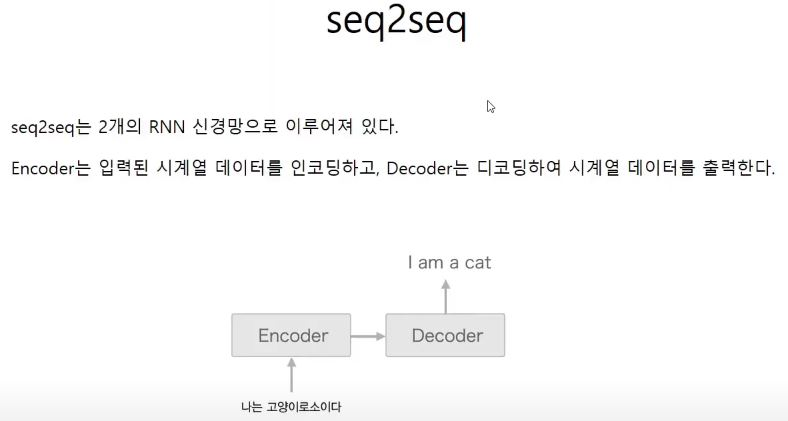

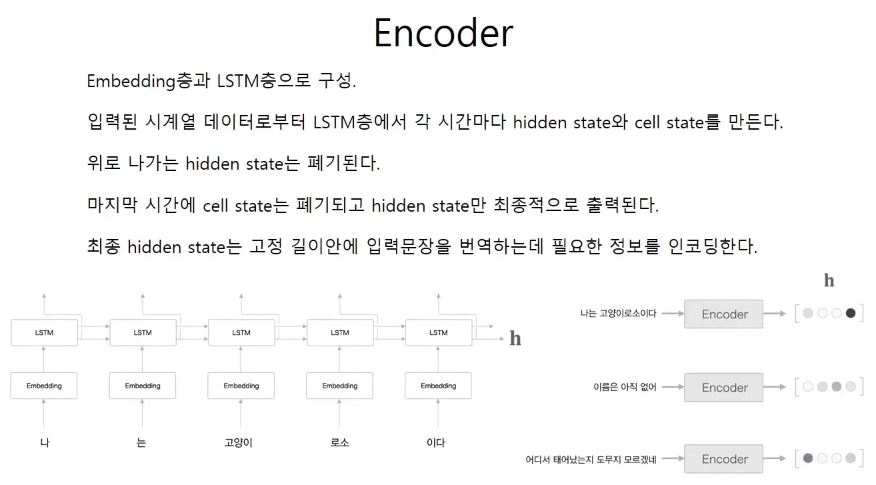

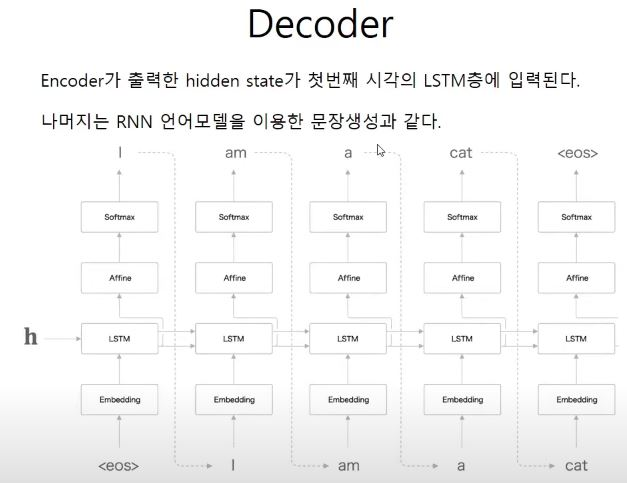

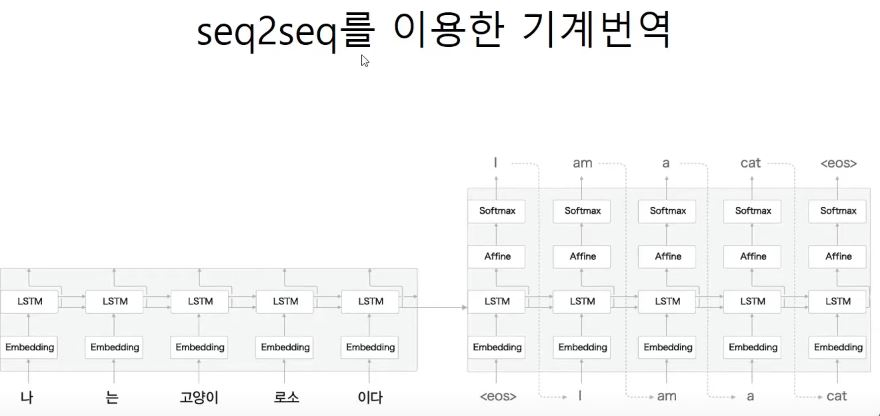

Chatbot (Automatic Response)

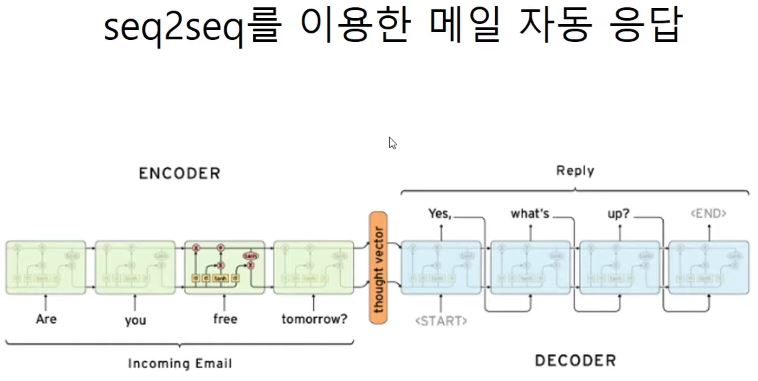

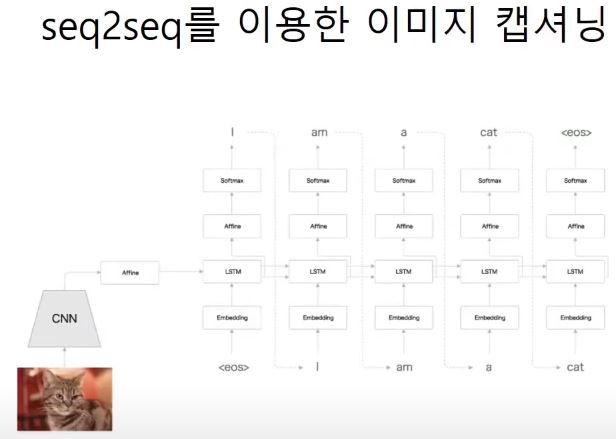
<br>
encoder: CNN <br>
decoder: RNN

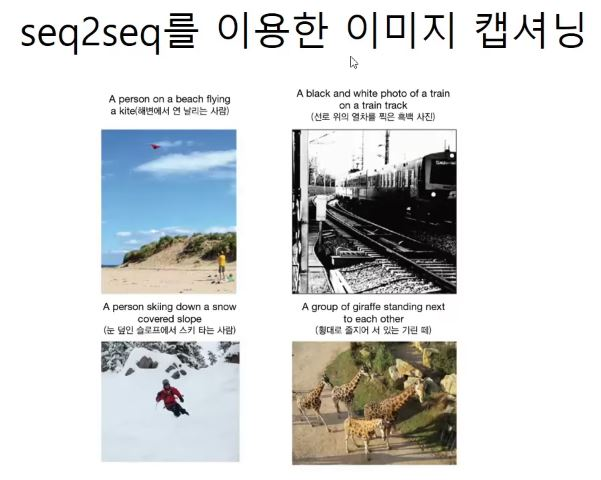

In [ ]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = False)
        
        # merging lists
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        
        return hs[:, -1, :]
    
    def backward(self, hd):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        
        return dout

In [ ]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed = TimeEmbedding(embed_W)
        # stateful = True: in order to receive the hidden state
        # from the encoder
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, xs, h):
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh # toward encoder
        
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h) # h: from the encoder
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
            
        return sampled

In [ ]:
class Seq2Seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftMaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.params
        
    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]
        
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        
        return loss
    
    def backward(self, dout = 1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        
        return dout
    
    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        
        return sampled

# RNN, LSTM Using Frameworks
---

## Implementing and Training a RNN

In [24]:
import tensorflow as tf

## Hyperparameters

In [25]:
EPOCHS = 10
NUM_WORDS = 10000

## Defining a Model

In [26]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # embedding necessary
        # since random two sentences are not the same in terms of meaning..
        # converting into a vector with its length being 16
        self.emb = tf.keras.layers.Embedding(NUM_WORDS, 16)
        self.lstm = tf.keras.layers.LSTM(32)
        # binary classification
        self.dense = tf.keras.layers.Dense(1, activation = 'sigmoid')
    
    def call(self, x, training = None, mask = None):
        x = self.emb(x)
        x = self.lstm(x)
        return self.dense(x)

## IMDB Dataset

In [27]:
imdb = tf.keras.datasets.imdb
# imdb -> sentence (comments regarding a movie) input and binary response (0 or 1)
# It cannot be implemented to use all words.
# Thus, use up to 10,000 words (maximum).
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = NUM_WORDS)

# '1': sos (start of sequence), which is located in the first sentence of each list
# '1' doesn't have meaning. It exists only functionally.
# The others correspond to English words.
# The more frequent the usage of a word, the less the corresponding number.
print(x_train)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

In [28]:
# The lengths of sentences are different each other.
# The lengths of sentences are too long.
print(len(x_train[0]), len(x_train[1]))

218 189


In [29]:
# Use only a part of each sentence to efficiently train a model.
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train,
    value = 0, # zero padding
    padding = 'pre', # padding forward
    maxlen = 32)
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test,
    value = 0,
    padding = 'pre',
    maxlen = 32)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## Generating a Model

In [30]:
model = MyModel()
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

## Training

In [31]:
model.fit(train_ds, validation_data = test_ds, epochs = EPOCHS)

Epoch 1/10
782/782 [==============================] - 12s 12ms/step - loss: 0.5061 - accuracy: 0.7391 - val_loss: 0.4358 - val_accuracy: 0.7953
Epoch 2/10
782/782 [==============================] - 10s 13ms/step - loss: 0.3726 - accuracy: 0.8319 - val_loss: 0.4514 - val_accuracy: 0.7902
Epoch 3/10
782/782 [==============================] - 10s 13ms/step - loss: 0.3240 - accuracy: 0.8587 - val_loss: 0.4657 - val_accuracy: 0.7846
Epoch 4/10
782/782 [==============================] - 10s 13ms/step - loss: 0.2756 - accuracy: 0.8869 - val_loss: 0.5335 - val_accuracy: 0.7760
Epoch 5/10
782/782 [==============================] - 10s 12ms/step - loss: 0.2216 - accuracy: 0.9112 - val_loss: 0.6037 - val_accuracy: 0.7693
Epoch 6/10
782/782 [==============================] - 9s 12ms/step - loss: 0.1682 - accuracy: 0.9350 - val_loss: 0.7436 - val_accuracy: 0.7579
Epoch 7/10
782/782 [==============================] - 9s 12ms/step - loss: 0.1270 - accuracy: 0.9523 - val_loss: 1.0038 - val_accuracy: 0

There seems to be overfitting issue since the training loss gets smaller while the validation loss increases.

## Gated Recurrent Unit (GRU)

In [32]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # embedding necessary
        # since random two sentences are not the same in terms of meaning..
        # converting into a vector with its length being 16
        # applying GRU
        self.emb = tf.keras.layers.Embedding(NUM_WORDS, 16)
        self.gru = tf.keras.layers.GRU(32)
        # binary classification
        self.dense = tf.keras.layers.Dense(1, activation = 'sigmoid')
    
    def call(self, x, training = None, mask = None):
        x = self.emb(x)
        # applying GRU
        x = self.gru(x)
        return self.dense(x)

In [33]:
model = MyModel()
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [34]:
model.fit(train_ds, validation_data = test_ds, epochs = EPOCHS)

Epoch 1/10
782/782 [==============================] - 10s 11ms/step - loss: 0.5149 - accuracy: 0.7280 - val_loss: 0.4491 - val_accuracy: 0.7902
Epoch 2/10
782/782 [==============================] - 9s 11ms/step - loss: 0.3768 - accuracy: 0.8332 - val_loss: 0.4599 - val_accuracy: 0.7867
Epoch 3/10
782/782 [==============================] - 9s 11ms/step - loss: 0.3281 - accuracy: 0.8606 - val_loss: 0.4780 - val_accuracy: 0.7776
Epoch 4/10
782/782 [==============================] - 9s 11ms/step - loss: 0.2853 - accuracy: 0.8838 - val_loss: 0.5410 - val_accuracy: 0.7748
Epoch 5/10
782/782 [==============================] - 9s 11ms/step - loss: 0.2380 - accuracy: 0.9082 - val_loss: 0.6161 - val_accuracy: 0.7700
Epoch 6/10
782/782 [==============================] - 9s 11ms/step - loss: 0.1933 - accuracy: 0.9288 - val_loss: 0.6776 - val_accuracy: 0.7670
Epoch 7/10
782/782 [==============================] - 9s 11ms/step - loss: 0.1570 - accuracy: 0.9447 - val_loss: 0.8094 - val_accuracy: 0.758

It appears that applying GRU does not work.. \
Still decreasing training loss and increasing validation loss..

## Vanilla RNN

In [35]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # embedding necessary
        # since random two sentences are not the same in terms of meaning..
        # converting into a vector with its length being 16
        # applying GRU
        self.emb = tf.keras.layers.Embedding(NUM_WORDS, 16)
        self.rnn = tf.keras.layers.SimpleRNN(32)
        # binary classification
        self.dense = tf.keras.layers.Dense(1, activation = 'sigmoid')
    
    def call(self, x, training = None, mask = None):
        x = self.emb(x)
        # applying GRU
        x = self.rnn(x)
        return self.dense(x)

In [36]:
model = MyModel()
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [37]:
model.fit(train_ds, validation_data = test_ds, epochs = EPOCHS)

Epoch 1/10
782/782 [==============================] - 61s 77ms/step - loss: 0.5879 - accuracy: 0.6614 - val_loss: 0.4661 - val_accuracy: 0.7783
Epoch 2/10
782/782 [==============================] - 61s 78ms/step - loss: 0.3702 - accuracy: 0.8378 - val_loss: 0.4745 - val_accuracy: 0.7786
Epoch 3/10
782/782 [==============================] - 56s 71ms/step - loss: 0.2204 - accuracy: 0.9152 - val_loss: 0.5792 - val_accuracy: 0.7692
Epoch 4/10
782/782 [==============================] - 53s 67ms/step - loss: 0.1058 - accuracy: 0.9658 - val_loss: 0.7431 - val_accuracy: 0.7520
Epoch 5/10
782/782 [==============================] - 53s 67ms/step - loss: 0.0532 - accuracy: 0.9843 - val_loss: 0.9278 - val_accuracy: 0.7523
Epoch 6/10
782/782 [==============================] - 53s 67ms/step - loss: 0.0286 - accuracy: 0.9924 - val_loss: 1.0894 - val_accuracy: 0.7379
Epoch 7/10
782/782 [==============================] - 53s 68ms/step - loss: 0.0201 - accuracy: 0.9943 - val_loss: 1.1707 - val_accuracy:

In this dataset, it seems that RNN is not effective.. To improve the model's performance, adding an attention layer might do the trick..